<a href="https://colab.research.google.com/github/biniwollo/Fall24-DSA-5900/blob/main/Non_federated_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  #import TensorFlow
import tensorflow as tf
print(tf.__version__)

2.17.0


In [2]:
import yfinance as yf
import os
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np

In [3]:
# Define the companies and their ticker symbols
companies = {
    'John Deere': 'DE',
    'Archer-Daniels-Midland': 'ADM',
    'Bunge Ltd': 'BG',
    'The Mosaic Company': 'MOS',
    'Corteva': 'CTVA'
}

# Set up directory in the default Colab environment
base_dir = '/content/FinancialData'
os.makedirs(base_dir, exist_ok=True)

stock_data_dict = {}

# Loop through each company and download the stock data
for company, ticker in companies.items():
    print(f"Downloading data for {company} ({ticker})...")
    stock_data = yf.download(ticker, start='2019-09-16', end='2024-09-13')
    file_path = os.path.join(base_dir, f"{ticker}_stock_data.csv")
    stock_data.to_csv(file_path)
    stock_data.columns = stock_data.columns.droplevel(1)
    stock_data_dict[ticker] = stock_data
    print(f"Data for {company} ({ticker}) saved successfully at {file_path}")

# Combine all data into a single CSV (optional)
combined_file_path = os.path.join(base_dir, "combined_stock_data.csv")
combined_stock_data = pd.concat([pd.read_csv(os.path.join(base_dir, f"{ticker}_stock_data.csv")) for ticker in companies.values()])
combined_stock_data.to_csv(combined_file_path, index=False)
print(f"Combined stock data saved at: {combined_file_path}")

[*********************100%***********************]  1 of 1 completed


Data for John Deere (DE) saved successfully at /content/FinancialData/DE_stock_data.csv


[*********************100%***********************]  1 of 1 completed


Data for Archer-Daniels-Midland (ADM) saved successfully at /content/FinancialData/ADM_stock_data.csv


[*********************100%***********************]  1 of 1 completed


Data for Bunge Ltd (BG) saved successfully at /content/FinancialData/BG_stock_data.csv


[*********************100%***********************]  1 of 1 completed


Data for The Mosaic Company (MOS) saved successfully at /content/FinancialData/MOS_stock_data.csv


[*********************100%***********************]  1 of 1 completed


Data for Corteva (CTVA) saved successfully at /content/FinancialData/CTVA_stock_data.csv
Combined stock data saved at: /content/FinancialData/combined_stock_data.csv


In [4]:
def splitDF(df):
  column_indices = {name: i for i, name in enumerate(df.columns)}

  n = len(df)
  train_df = df[0:int(n*0.7)]
  val_df = df[int(n*0.7):int(n*0.9)]
  test_df = df[int(n*0.9):]

  num_features = df.shape[1]

  train_mean = train_df.mean()
  train_std = train_df.std()

  train_df = (train_df - train_mean) / train_std
  val_df = (val_df - train_mean) / train_std
  test_df = (test_df - train_mean) / train_std

  return train_df, val_df, test_df

In [5]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [6]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [7]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normalized]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')
  plt.show()

WindowGenerator.plot = plot

In [8]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [9]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [10]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, 50, 1])

def Baseline1(window, multi_val_performance, multi_performance):
  last_baseline = MultiStepLastBaseline()
  last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

  multi_val_performance['Baseline'] = last_baseline.evaluate(window.val, return_dict=True)
  multi_performance['Baseline'] = last_baseline.evaluate(window.test, verbose=0, return_dict=True)
  window.plot(last_baseline)

In [11]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

def Baseline2(window, multi_val_performance, multi_performance):
  repeat_baseline = RepeatBaseline()
  repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                          metrics=[tf.keras.metrics.MeanAbsoluteError()])

  multi_val_performance['Repeat'] = repeat_baseline.evaluate(window.val, return_dict=True)
  multi_performance['Repeat'] = repeat_baseline.evaluate(window.test, verbose=0, return_dict=True)
  window.plot(repeat_baseline)


In [12]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [13]:
def LinearModel(window, outSteps, multi_val_performance, multi_performance):
  num_features = 1
  linear_model = tf.keras.Sequential([
      # Take the last time-step.
      # Shape [batch, time, features] => [batch, 1, features]
      tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
      # Shape => [batch, 1, out_steps*features]
      tf.keras.layers.Dense(outSteps*num_features,
                            kernel_initializer=tf.initializers.zeros()),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([outSteps, num_features])
  ])

  history = compile_and_fit(linear_model, window)

  multi_val_performance['Linear'] = linear_model.evaluate(window.val, return_dict=True)
  multi_performance['Linear'] = linear_model.evaluate(window.test, verbose=0, return_dict=True)
  window.plot(linear_model)

In [14]:
def DenseModel(window, outSteps, multi_val_performance, multi_performance):
  num_features = 1
  multi_dense_model = tf.keras.Sequential([
      # Take the last time step.
      # Shape [batch, time, features] => [batch, 1, features]
      tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
      # Shape => [batch, 1, dense_units]
      tf.keras.layers.Dense(512, activation='relu'),
      # Shape => [batch, out_steps*features]
      tf.keras.layers.Dense(outSteps*num_features,
                          kernel_initializer=tf.initializers.zeros()),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([outSteps, num_features])])

  history = compile_and_fit(multi_dense_model, window)

  multi_val_performance['Dense'] = multi_dense_model.evaluate(window.val, return_dict=True)
  multi_performance['Dense'] = multi_dense_model.evaluate(window.test, verbose=0, return_dict=True)
  window.plot(multi_dense_model)

In [15]:
def ConvModel(window, outSteps, convWidth, multi_val_performance, multi_performance):
  num_features=1
  multi_conv_model = tf.keras.Sequential([
      # Shape [batch, time, features] => [batch, convWidth, features]
      tf.keras.layers.Lambda(lambda x: x[:, -convWidth:, :]),
      # Shape => [batch, 1, conv_units]
      tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(convWidth)),
      # Shape => [batch, 1,  out_steps*features]
      tf.keras.layers.Dense(outSteps*num_features,
                            kernel_initializer=tf.initializers.zeros()),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([outSteps, num_features])
  ])

  history = compile_and_fit(multi_conv_model, window)

  multi_val_performance['Conv'] = multi_conv_model.evaluate(window.val, return_dict=True)
  multi_performance['Conv'] = multi_conv_model.evaluate(window.test, verbose=0, return_dict=True)
  window.plot(multi_conv_model)

In [16]:
def LSTM(window, outSteps, multi_val_performance, multi_performance):
  num_features=1
  multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(outSteps*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([outSteps, num_features])
  ])

  history = compile_and_fit(multi_lstm_model, window)

  multi_val_performance['LSTM'] = multi_lstm_model.evaluate(window.val, return_dict=True)
  multi_performance['LSTM'] = multi_lstm_model.evaluate(window.test, verbose=0, return_dict=True)
  window.plot(multi_lstm_model)

In [17]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(6)

def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

def AR_LSTM(window, outSteps, multi_val_performance, multi_performance):
  feedback_model = FeedBack(units=32, out_steps=outSteps)
  history = compile_and_fit(feedback_model, window)

  multi_val_performance['AR LSTM'] = feedback_model.evaluate(window.val, return_dict=True)
  multi_performance['AR LSTM'] = feedback_model.evaluate(window.test, verbose=0, return_dict=True)
  window.plot(feedback_model)

In [23]:
def printModelSummary(multi_val_performance, multi_performance):
  x = np.arange(len(multi_performance))
  width = 0.3

  metric_name = 'mean_absolute_error'
  val_mae = [v[metric_name] for v in multi_val_performance.values()]
  test_mae = [v[metric_name] for v in multi_performance.values()]

  plt.bar(x - 0.17, val_mae, width, label='Validation')
  plt.bar(x + 0.17, test_mae, width, label='Test')
  plt.xticks(ticks=x, labels=multi_performance.keys(),
            rotation=45)
  plt.ylabel(f'MAE (average over all times and outputs)')
  _ = plt.legend()
  plt.show()

In [24]:
def run_experiment(ticker, df):
  print('RUNNING EXPERIMENT FOR ' + ticker)
  train_df, val_df, test_df = splitDF(df)

  OUT_STEPS = 50
  CONV_WIDTH = 3
  window = WindowGenerator(input_width=50, label_width=OUT_STEPS, shift=OUT_STEPS, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Close'])

  multi_val_performance = {}
  multi_performance = {}

  print ('Baseline 1 (Last Price):')
  Baseline1(window, multi_val_performance, multi_performance)
  print ('Baseline 2 (Repeat):')
  Baseline2(window, multi_val_performance, multi_performance)
  print ('Linear Model:')
  LinearModel(window, OUT_STEPS, multi_val_performance, multi_performance)
  print ('Dense Model:')
  DenseModel(window, OUT_STEPS, multi_val_performance, multi_performance)
  print ('CNN Model:')
  ConvModel(window, OUT_STEPS, CONV_WIDTH, multi_val_performance, multi_performance)
  print ('LSTM:')
  LSTM(window, OUT_STEPS, multi_val_performance, multi_performance)
  print ('AR LSTM:')
  AR_LSTM(window, OUT_STEPS, multi_val_performance, multi_performance)

  print(multi_val_performance)
  print(multi_performance)

  printModelSummary(multi_val_performance, multi_performance)


In [25]:
def run_group_experiment():
  for ticker, df in stock_data_dict.items():
    run_experiment(ticker, df)

RUNNING EXPERIMENT FOR DE
Baseline 1 (Last Price):
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3898 - mean_absolute_error: 0.3939  


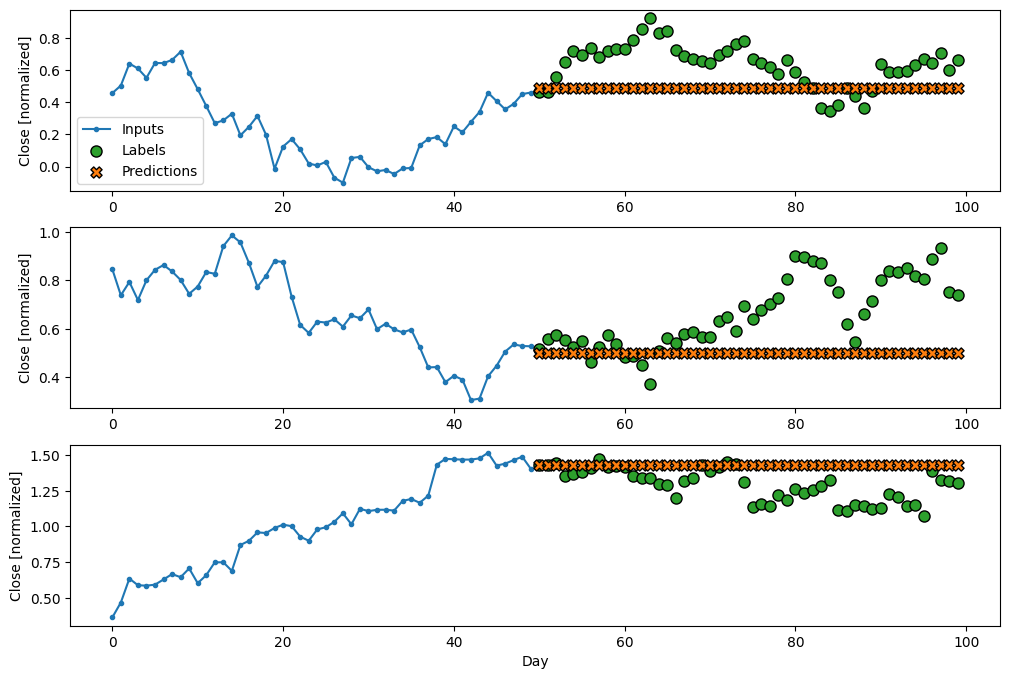

Baseline 2 (Repeat):
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4885 - mean_absolute_error: 0.4830  


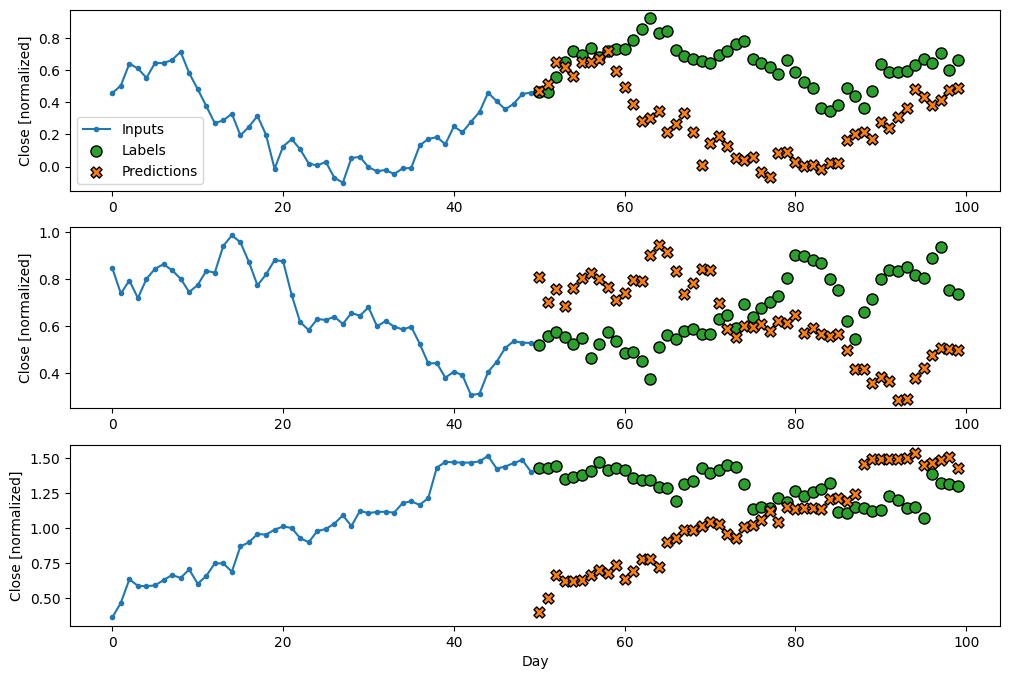

Linear Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8513 - mean_absolute_error: 0.8192 - val_loss: 0.7433 - val_mean_absolute_error: 0.8343
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6551 - mean_absolute_error: 0.7080 - val_loss: 0.5473 - val_mean_absolute_error: 0.7071
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5068 - mean_absolute_error: 0.6212 - val_loss: 0.4023 - val_mean_absolute_error: 0.5944
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4026 - mean_absolute_error: 0.5489 - val_loss: 0.2913 - val_mean_absolute_error: 0.4896
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3012 - mean_absolute_error: 0.4672 - val_loss: 0.2117 - val_mean_absolute_error: 0.3974
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2409 - mean_absolute_error: 0.4123 - val_loss: 0.1573 - val_mean_absolute_error: 0.3272
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1833 - mean_absolute_error: 0.3520 -

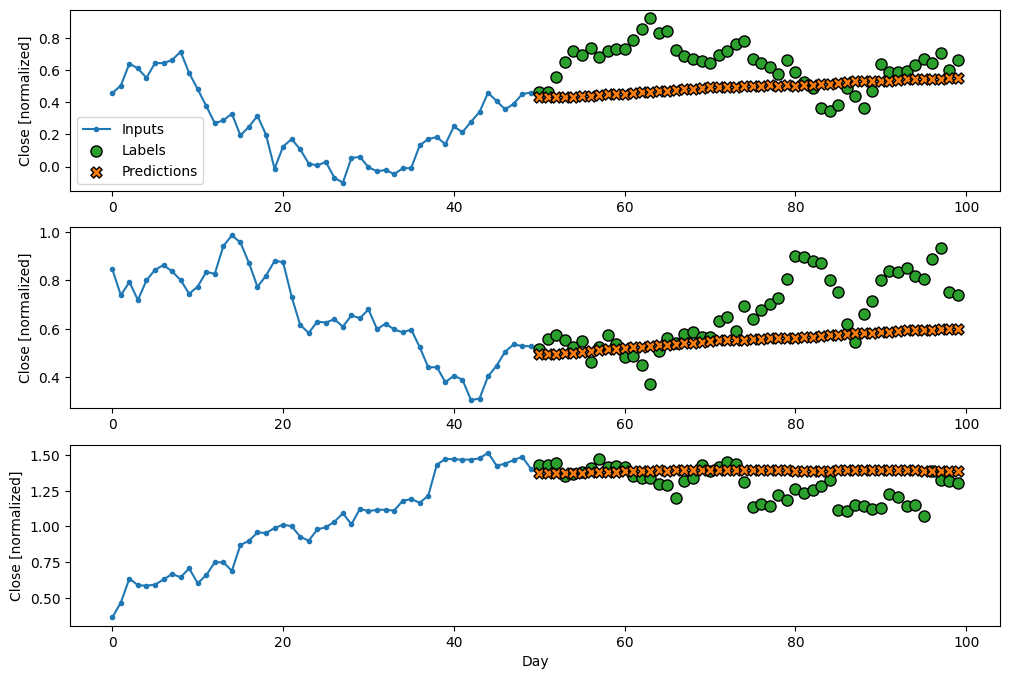

Dense Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.6042 - mean_absolute_error: 0.6569 - val_loss: 0.1466 - val_mean_absolute_error: 0.3162
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1311 - mean_absolute_error: 0.2897 - val_loss: 0.0707 - val_mean_absolute_error: 0.2038
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0962 - mean_absolute_error: 0.2355 - val_loss: 0.0643 - val_mean_absolute_error: 0.1980
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0848 - mean_absolute_error: 0.2207 - val_loss: 0.0613 - val_mean_absolute_error: 0.1924
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0832 - mean_absolute_error: 0.2186 - val_loss: 0.0598 - val_mean_absolute_error: 0.1890
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0787 - mean_absolute_error: 0.2135 - val_loss: 0.0555 - val_mean_absolute_error: 0.1850
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0754 - mean_absolute_error: 0.2083 - 

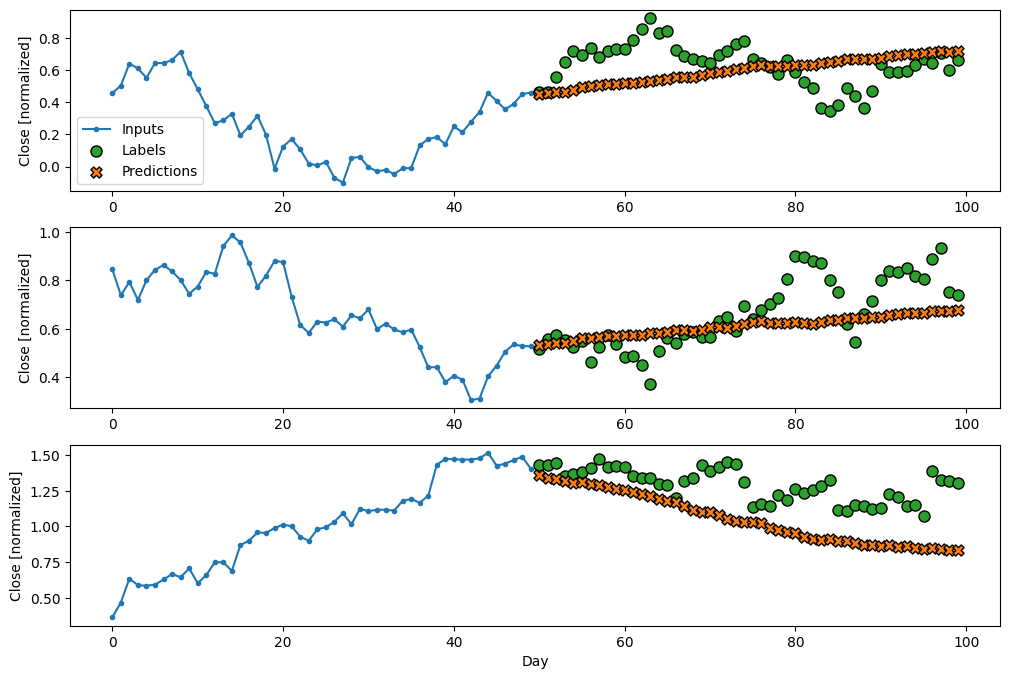

CNN Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6668 - mean_absolute_error: 0.6973 - val_loss: 0.1481 - val_mean_absolute_error: 0.3158
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1287 - mean_absolute_error: 0.2822 - val_loss: 0.0714 - val_mean_absolute_error: 0.2073
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0937 - mean_absolute_error: 0.2328 - val_loss: 0.0743 - val_mean_absolute_error: 0.2090
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0931 - mean_absolute_error: 0.2321 - val_loss: 0.0693 - val_mean_absolute_error: 0.2018
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0858 - mean_absolute_error: 0.2227 - val_loss: 0.0757 - val_mean_absolute_error: 0.2088
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0830 - mean_absolute_error: 0.2183 - val_loss: 0.0622 - val_mean_absolute_error: 0.1943
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0776 - mean_absolute_error: 0.2107 - val

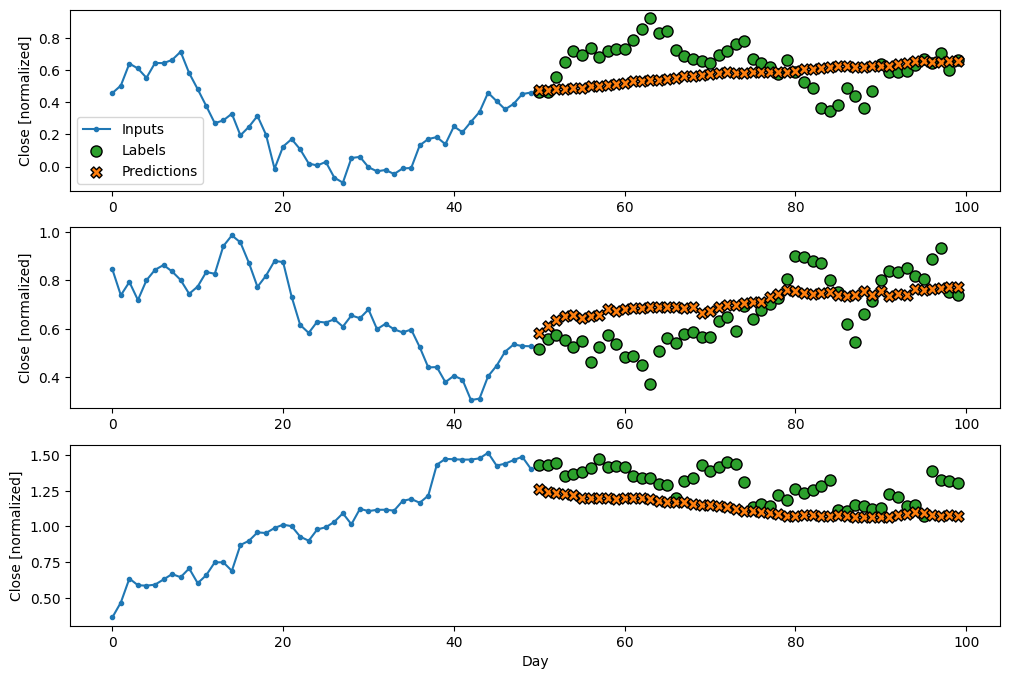

LSTM:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.8491 - mean_absolute_error: 0.8129 - val_loss: 0.5014 - val_mean_absolute_error: 0.6724
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3897 - mean_absolute_error: 0.5113 - val_loss: 0.1494 - val_mean_absolute_error: 0.3181
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.1554 - mean_absolute_error: 0.3155 - val_loss: 0.1092 - val_mean_absolute_error: 0.2588
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0957 - mean_absolute_error: 0.2411 - val_loss: 0.0920 - val_mean_absolute_error: 0.2333
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0899 - mean_absolute_error: 0.2337 - val_loss: 0.0900 - val_mean_absolute_error: 0.2305
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0878 - mean_absolute_error: 0.2306 - val_loss: 0.0909 - val_mean_absolute_error: 0.2319
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0834 - mean_absolute_error: 0.2239 - va

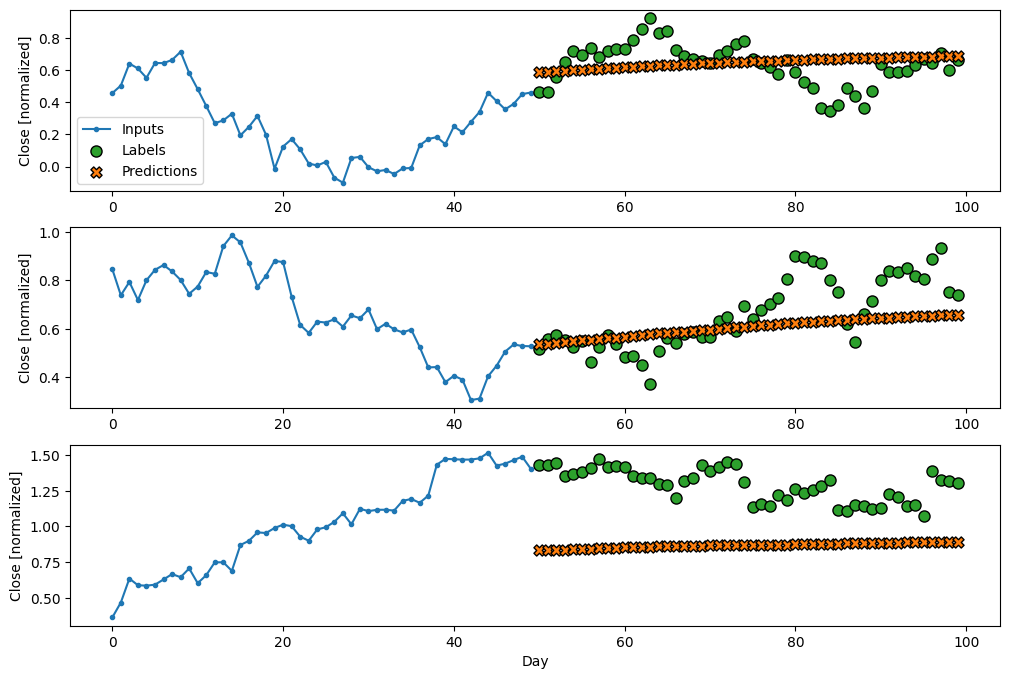

AR LSTM:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - loss: 0.9066 - mean_absolute_error: 0.8346 - val_loss: 0.2141 - val_mean_absolute_error: 0.3792
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.2860 - mean_absolute_error: 0.4182 - val_loss: 0.0921 - val_mean_absolute_error: 0.2339
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.1774 - mean_absolute_error: 0.3327 - val_loss: 0.1270 - val_mean_absolute_error: 0.2864
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1123 - mean_absolute_error: 0.2605 - val_loss: 0.0888 - val_mean_absolute_error: 0.2295
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0932 - mean_absolute_error: 0.2398 - val_loss: 0.0918 - val_mean_absolute_error: 0.2345
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0926 - mean_absolute_error: 0.2373 - val_loss: 0.0833 - val_mean_absolute_error: 0.2219
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0873 - mean_absolute_error: 0.2293

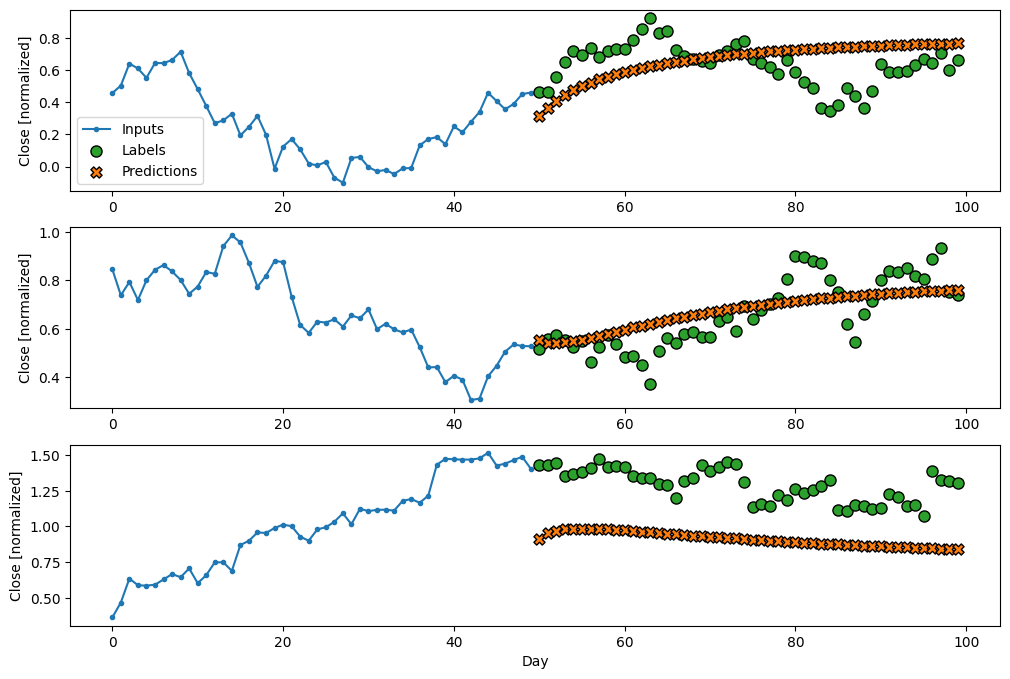

{'Baseline': {'loss': 0.41092029213905334, 'mean_absolute_error': 0.40726324915885925}, 'Repeat': {'loss': 0.4811362326145172, 'mean_absolute_error': 0.4784473180770874}, 'Linear': {'loss': 0.07449328154325485, 'mean_absolute_error': 0.2169259488582611}, 'Dense': {'loss': 0.05900413542985916, 'mean_absolute_error': 0.17999854683876038}, 'Conv': {'loss': 0.06271173804998398, 'mean_absolute_error': 0.19136494398117065}, 'LSTM': {'loss': 0.07821100205183029, 'mean_absolute_error': 0.21436791121959686}, 'AR LSTM': {'loss': 0.06227799504995346, 'mean_absolute_error': 0.19136719405651093}}
{'Baseline': {'loss': 0.39921021461486816, 'mean_absolute_error': 0.3053344190120697}, 'Repeat': {'loss': 0.3539758324623108, 'mean_absolute_error': 0.43919962644577026}, 'Linear': {'loss': 0.025135936215519905, 'mean_absolute_error': 0.12089858949184418}, 'Dense': {'loss': 0.020008854568004608, 'mean_absolute_error': 0.11452578008174896}, 'Conv': {'loss': 0.02124483324587345, 'mean_absolute_error': 0.1128

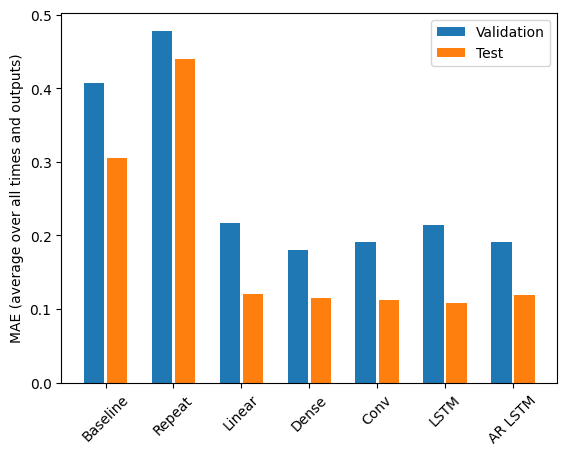

In [20]:
run_experiment('DE', stock_data_dict['DE'])

RUNNING EXPERIMENT FOR DE
Baseline 1 (Last Price):
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3943 - mean_absolute_error: 0.3993  


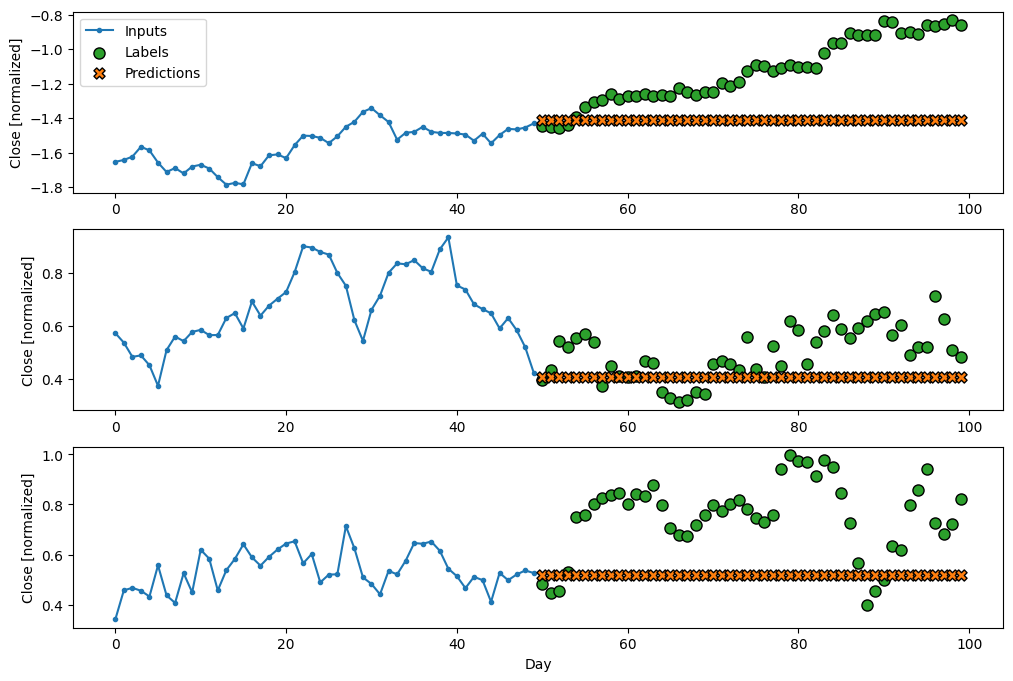

Baseline 2 (Repeat):
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4842 - mean_absolute_error: 0.4821  


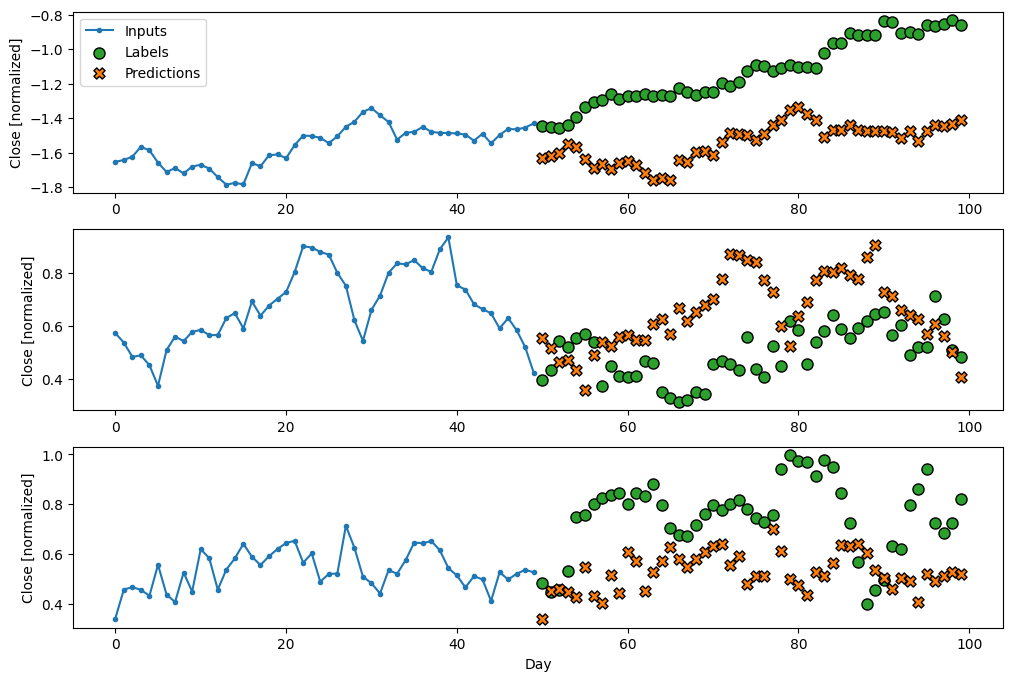

Linear Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8327 - mean_absolute_error: 0.8065 - val_loss: 0.7425 - val_mean_absolute_error: 0.8339
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6605 - mean_absolute_error: 0.7124 - val_loss: 0.5494 - val_mean_absolute_error: 0.7088
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4972 - mean_absolute_error: 0.6123 - val_loss: 0.4020 - val_mean_absolute_error: 0.5944
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3802 - mean_absolute_error: 0.5302 - val_loss: 0.2923 - val_mean_absolute_error: 0.4910
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3090 - mean_absolute_error: 0.4727 - val_loss: 0.2127 - val_mean_absolute_error: 0.3990
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2313 - mean_absolute_error: 0.4011 - val_loss: 0.1579 - val_mean_absolute_error: 0.3279
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1931 - mean_absolute_error: 0.3621 

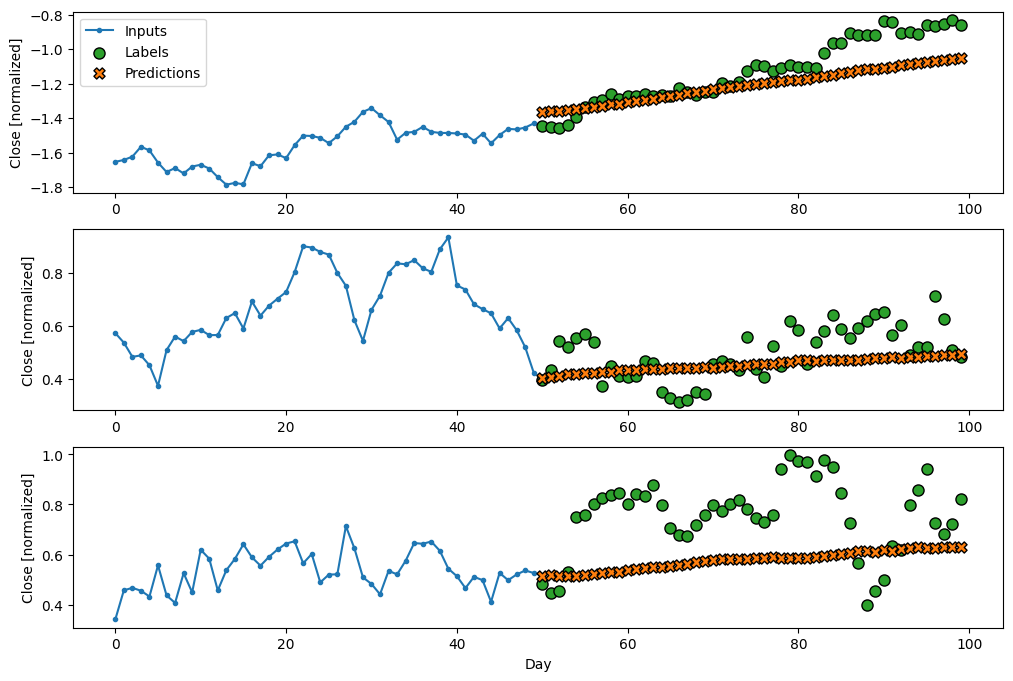

Dense Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6605 - mean_absolute_error: 0.6853 - val_loss: 0.1079 - val_mean_absolute_error: 0.2685
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1189 - mean_absolute_error: 0.2722 - val_loss: 0.0732 - val_mean_absolute_error: 0.2066
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0919 - mean_absolute_error: 0.2307 - val_loss: 0.0635 - val_mean_absolute_error: 0.1995
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0796 - mean_absolute_error: 0.2140 - val_loss: 0.0672 - val_mean_absolute_error: 0.1979
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0855 - mean_absolute_error: 0.2226 - val_loss: 0.0585 - val_mean_absolute_error: 0.1883
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0809 - mean_absolute_error: 0.2172 - val_loss: 0.0575 - val_mean_absolute_error: 0.1843
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0761 - mean_absolute_error: 0.2105 - 

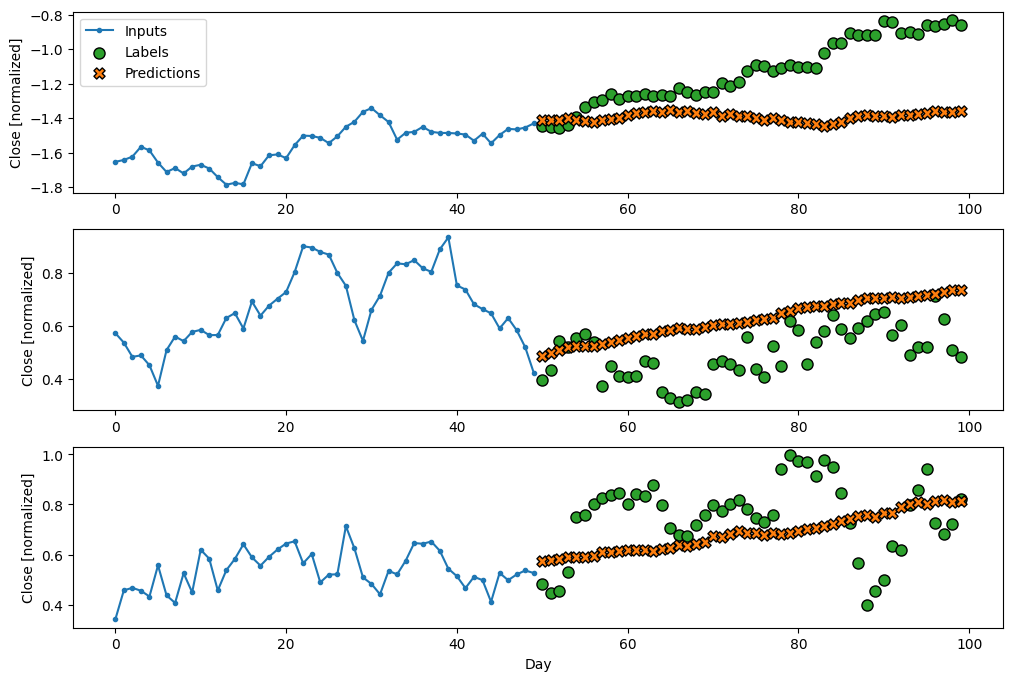

CNN Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.5995 - mean_absolute_error: 0.6506 - val_loss: 0.1747 - val_mean_absolute_error: 0.3449
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1432 - mean_absolute_error: 0.2971 - val_loss: 0.0692 - val_mean_absolute_error: 0.2052
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0990 - mean_absolute_error: 0.2380 - val_loss: 0.0676 - val_mean_absolute_error: 0.2043
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0955 - mean_absolute_error: 0.2352 - val_loss: 0.0670 - val_mean_absolute_error: 0.2054
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0916 - mean_absolute_error: 0.2300 - val_loss: 0.0669 - val_mean_absolute_error: 0.2078
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0833 - mean_absolute_error: 0.2171 - val_loss: 0.0623 - val_mean_absolute_error: 0.1966
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0842 - mean_absolute_error: 0.2218 - v

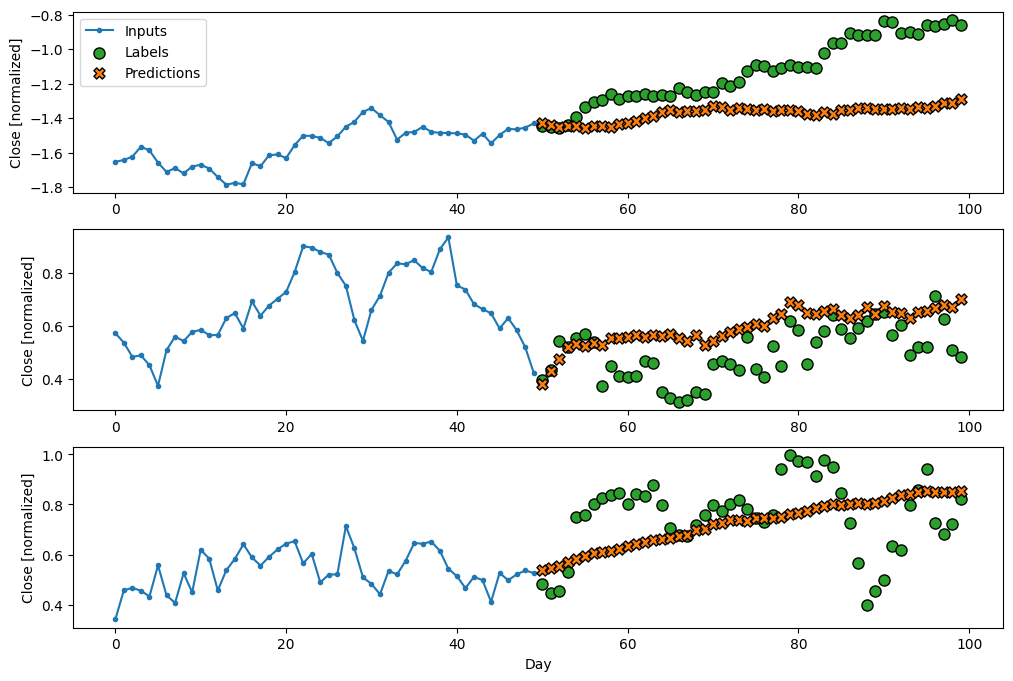

LSTM:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.8263 - mean_absolute_error: 0.8011 - val_loss: 0.4955 - val_mean_absolute_error: 0.6680
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.3699 - mean_absolute_error: 0.4982 - val_loss: 0.1401 - val_mean_absolute_error: 0.3046
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1484 - mean_absolute_error: 0.3098 - val_loss: 0.1007 - val_mean_absolute_error: 0.2463
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0978 - mean_absolute_error: 0.2459 - val_loss: 0.0911 - val_mean_absolute_error: 0.2322
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0868 - mean_absolute_error: 0.2299 - val_loss: 0.0785 - val_mean_absolute_error: 0.2141
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0858 - mean_absolute_error: 0.2290 - val_loss: 0.0783 - val_mean_absolute_error: 0.2139
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0845 - mean_absolute_error: 0.2268 - va

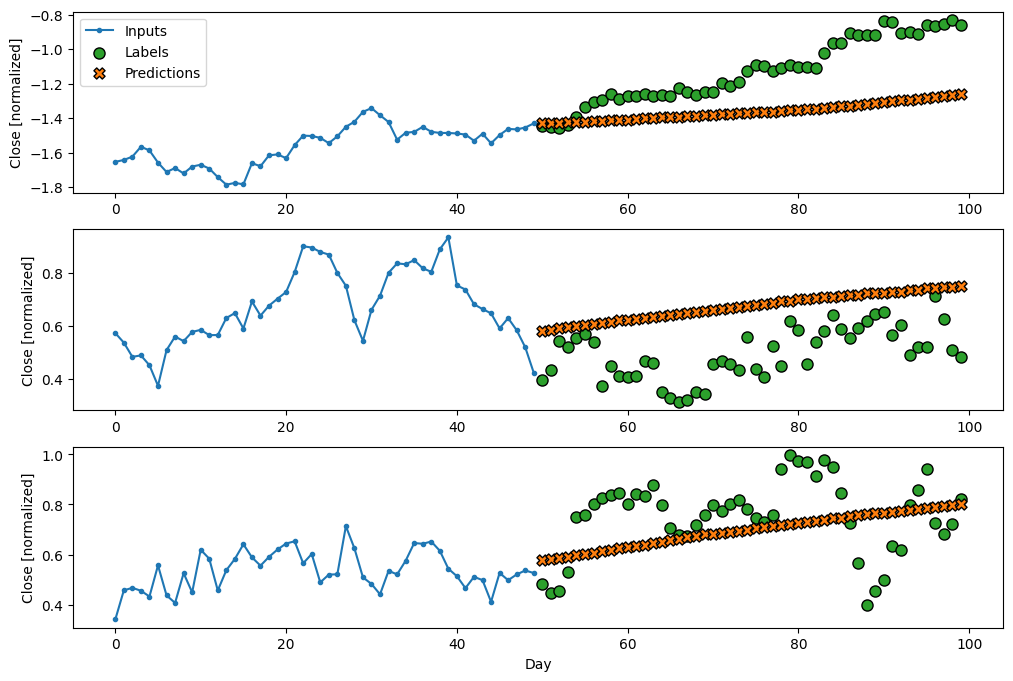

AR LSTM:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - loss: 0.7841 - mean_absolute_error: 0.7605 - val_loss: 0.2853 - val_mean_absolute_error: 0.4012
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.2708 - mean_absolute_error: 0.4087 - val_loss: 0.1661 - val_mean_absolute_error: 0.3344
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1331 - mean_absolute_error: 0.2890 - val_loss: 0.1156 - val_mean_absolute_error: 0.2701
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1079 - mean_absolute_error: 0.2552 - val_loss: 0.0998 - val_mean_absolute_error: 0.2472
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0887 - mean_absolute_error: 0.2276 - val_loss: 0.1059 - val_mean_absolute_error: 0.2574
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0906 - mean_absolute_error: 0.2307 - val_loss: 0.0694 - val_mean_absolute_error: 0.2012
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0855 - mean_absolute_error: 0.2237

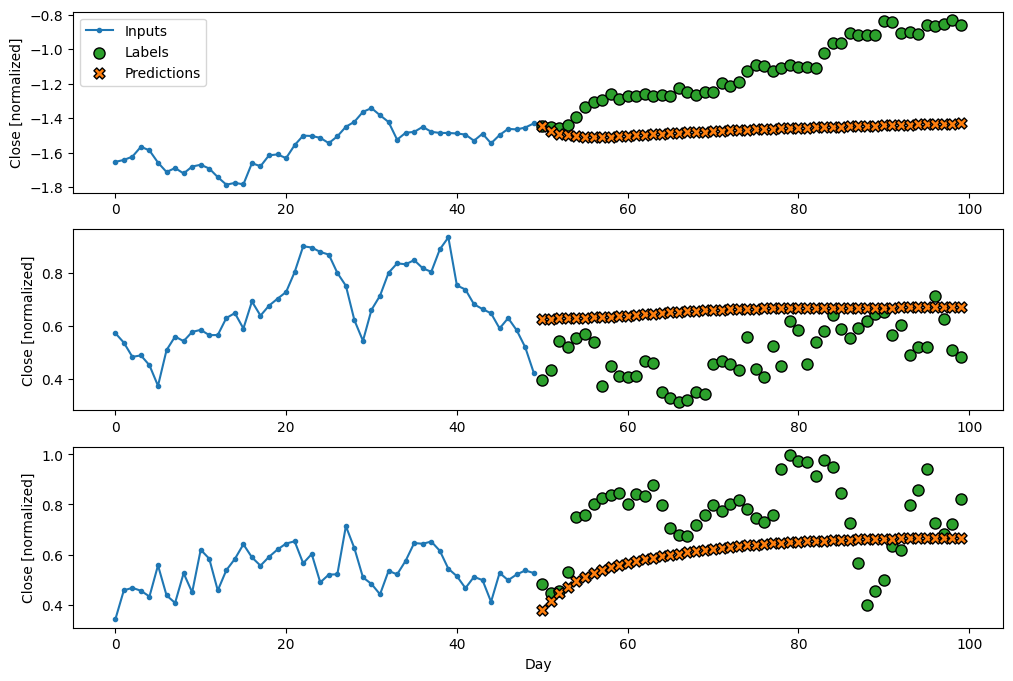

{'Baseline': {'loss': 0.41092029213905334, 'mean_absolute_error': 0.40726321935653687}, 'Repeat': {'loss': 0.4811362326145172, 'mean_absolute_error': 0.4784473180770874}, 'Linear': {'loss': 0.07516027241945267, 'mean_absolute_error': 0.21814005076885223}, 'Dense': {'loss': 0.04954636096954346, 'mean_absolute_error': 0.17115546762943268}, 'Conv': {'loss': 0.04671040549874306, 'mean_absolute_error': 0.17159968614578247}, 'LSTM': {'loss': 0.06641235202550888, 'mean_absolute_error': 0.1927371472120285}, 'AR LSTM': {'loss': 0.10908278822898865, 'mean_absolute_error': 0.26277613639831543}}
{'Baseline': {'loss': 0.39921021461486816, 'mean_absolute_error': 0.3053344488143921}, 'Repeat': {'loss': 0.3539758324623108, 'mean_absolute_error': 0.43919962644577026}, 'Linear': {'loss': 0.026560939848423004, 'mean_absolute_error': 0.12379349768161774}, 'Dense': {'loss': 0.02626814879477024, 'mean_absolute_error': 0.1229822039604187}, 'Conv': {'loss': 0.03622778132557869, 'mean_absolute_error': 0.145385

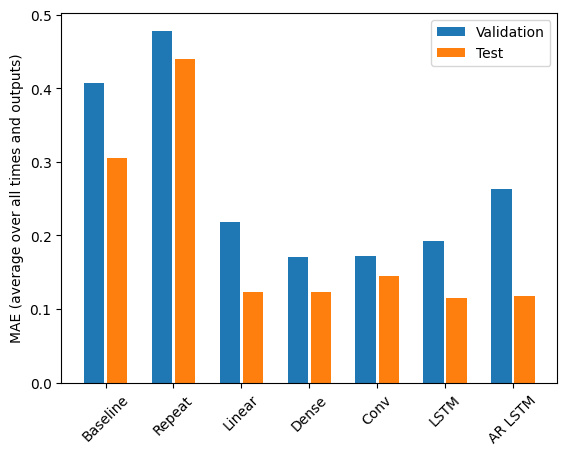

RUNNING EXPERIMENT FOR ADM
Baseline 1 (Last Price):
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4668 - mean_absolute_error: 0.4374  


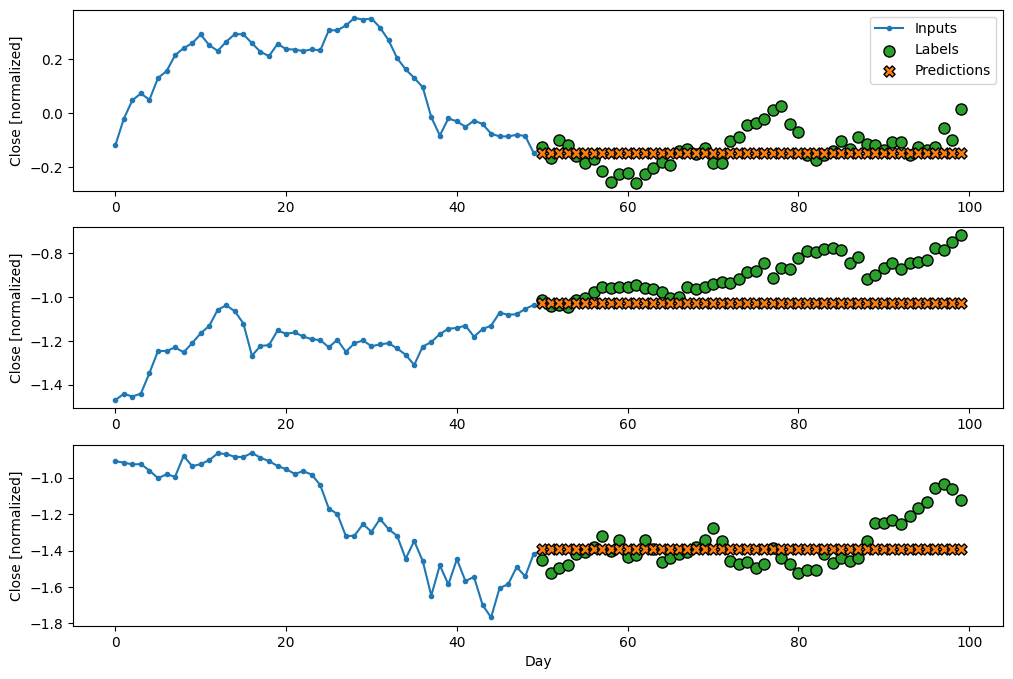

Baseline 2 (Repeat):
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4984 - mean_absolute_error: 0.5347  


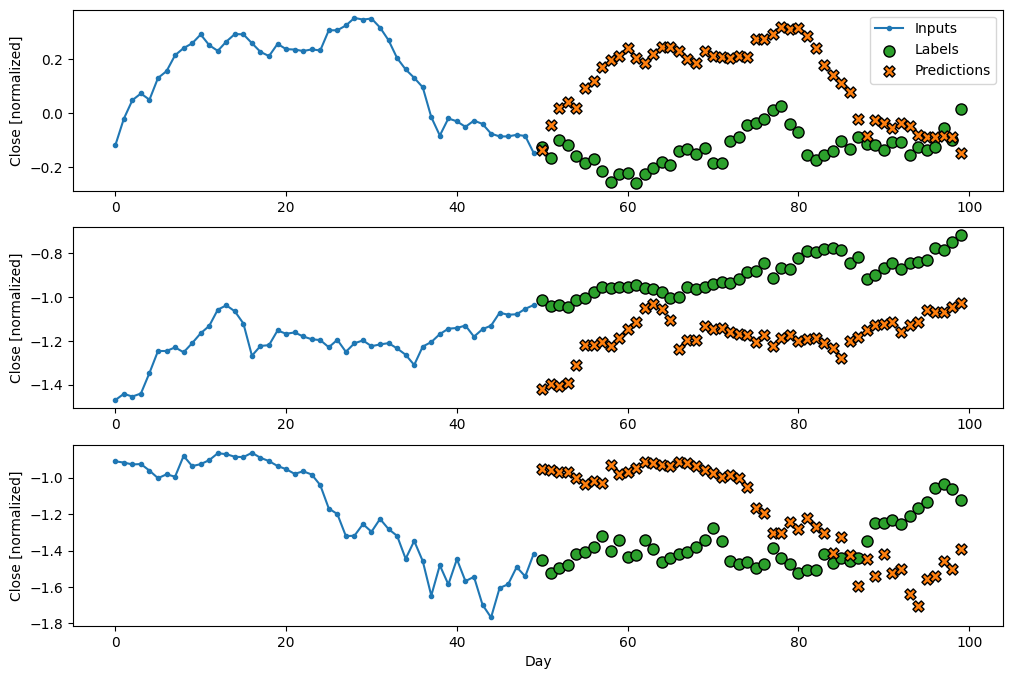

Linear Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9657 - mean_absolute_error: 0.8316 - val_loss: 0.4688 - val_mean_absolute_error: 0.6412
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7489 - mean_absolute_error: 0.7318 - val_loss: 0.3693 - val_mean_absolute_error: 0.5594
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5882 - mean_absolute_error: 0.6441 - val_loss: 0.2957 - val_mean_absolute_error: 0.4840
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4539 - mean_absolute_error: 0.5632 - val_loss: 0.2418 - val_mean_absolute_error: 0.4144
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3395 - mean_absolute_error: 0.4764 - val_loss: 0.2074 - val_mean_absolute_error: 0.3626
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2660 - mean_absolute_error: 0.4160 - val_loss: 0.1857 - val_mean_absolute_error: 0.3260
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2159 - mean_absolute_error: 0.3689 - 

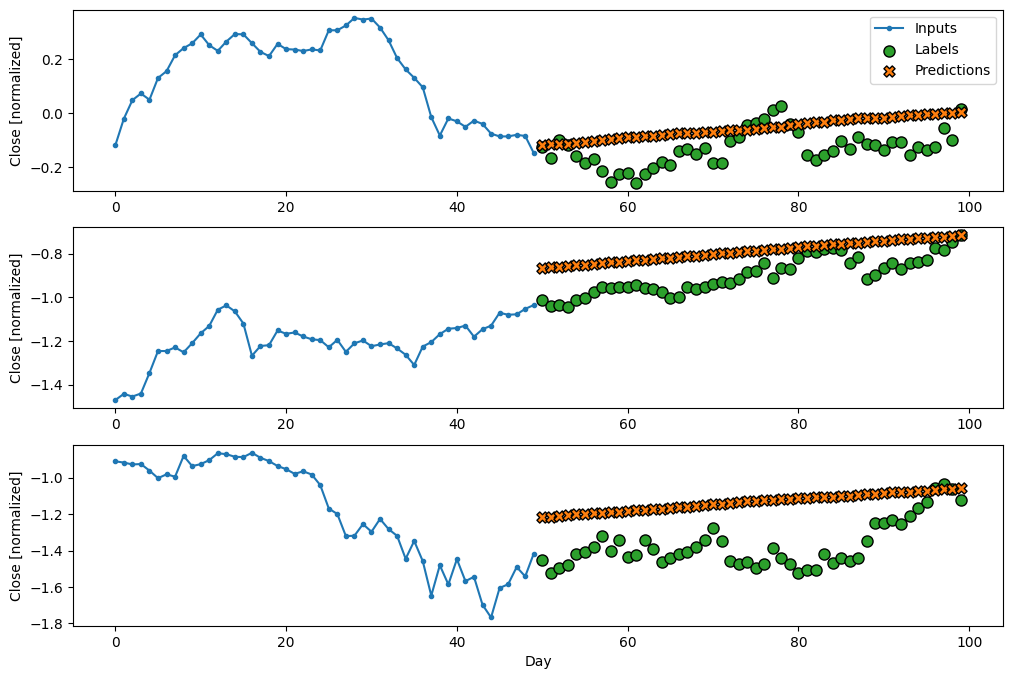

Dense Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.6112 - mean_absolute_error: 0.6269 - val_loss: 0.3015 - val_mean_absolute_error: 0.4298
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1317 - mean_absolute_error: 0.2803 - val_loss: 0.1928 - val_mean_absolute_error: 0.3087
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0982 - mean_absolute_error: 0.2263 - val_loss: 0.2348 - val_mean_absolute_error: 0.3556
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0973 - mean_absolute_error: 0.2254 - val_loss: 0.2107 - val_mean_absolute_error: 0.3320
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1922 - mean_absolute_error: 0.3203 


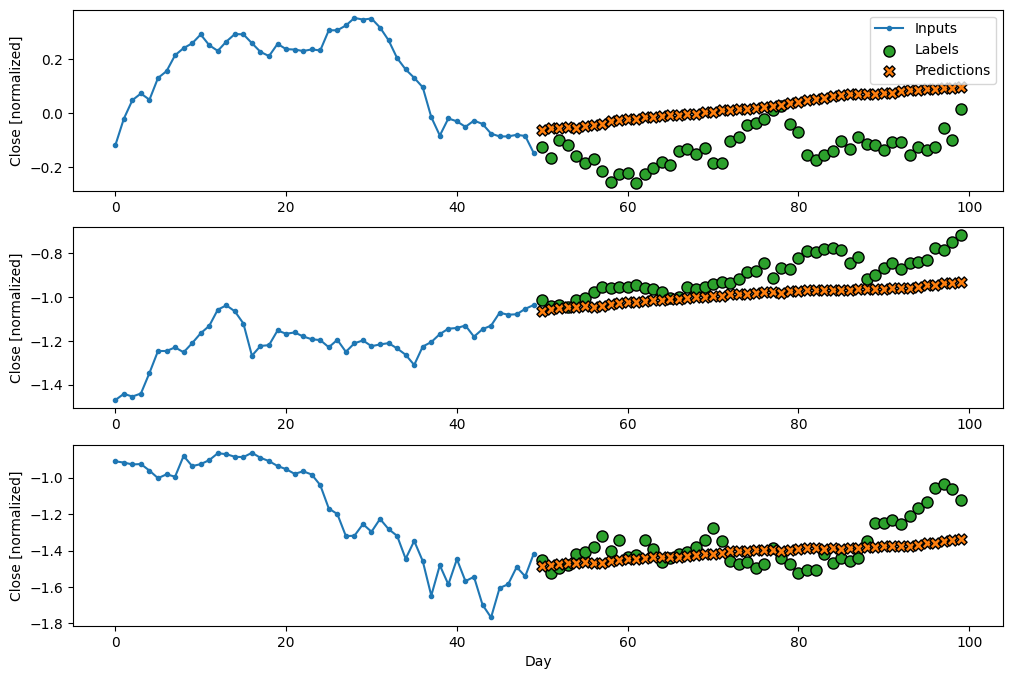

CNN Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7114 - mean_absolute_error: 0.6788 - val_loss: 0.2896 - val_mean_absolute_error: 0.4136
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1325 - mean_absolute_error: 0.2766 - val_loss: 0.1774 - val_mean_absolute_error: 0.2927
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1063 - mean_absolute_error: 0.2370 - val_loss: 0.1904 - val_mean_absolute_error: 0.3081
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1035 - mean_absolute_error: 0.2299 - val_loss: 0.2089 - val_mean_absolute_error: 0.3292
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2004 - mean_absolute_error: 0.3206 


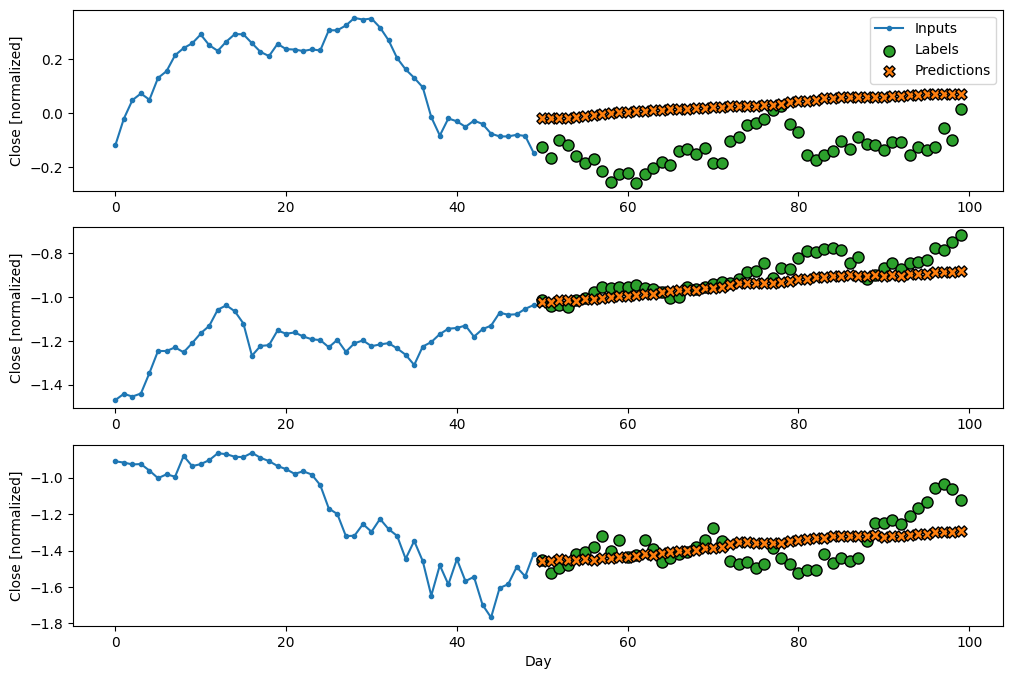

LSTM:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.8948 - mean_absolute_error: 0.7877 - val_loss: 0.2184 - val_mean_absolute_error: 0.3676
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.4095 - mean_absolute_error: 0.5342 - val_loss: 0.2904 - val_mean_absolute_error: 0.4007
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1670 - mean_absolute_error: 0.3334 - val_loss: 0.5032 - val_mean_absolute_error: 0.5828
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5193 - mean_absolute_error: 0.5836


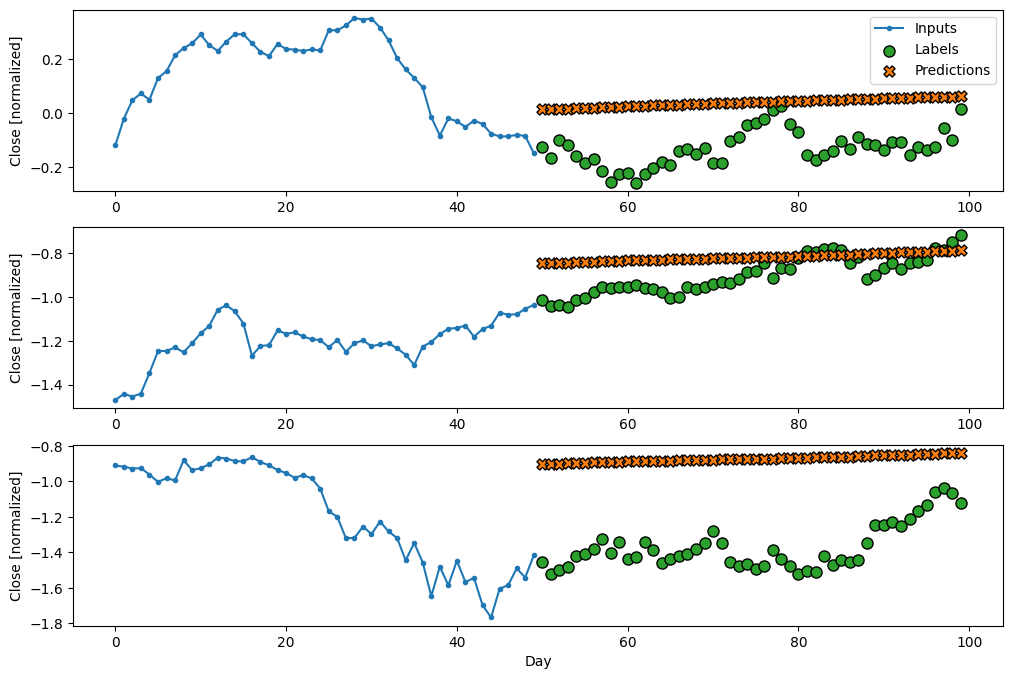

AR LSTM:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - loss: 0.8026 - mean_absolute_error: 0.7344 - val_loss: 0.4636 - val_mean_absolute_error: 0.5354
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.3042 - mean_absolute_error: 0.4465 - val_loss: 0.3747 - val_mean_absolute_error: 0.4622
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1845 - mean_absolute_error: 0.3385 - val_loss: 0.4815 - val_mean_absolute_error: 0.5318
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0981 - mean_absolute_error: 0.2392 - val_loss: 0.5446 - val_mean_absolute_error: 0.5819
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5873 - mean_absolute_error: 0.6031


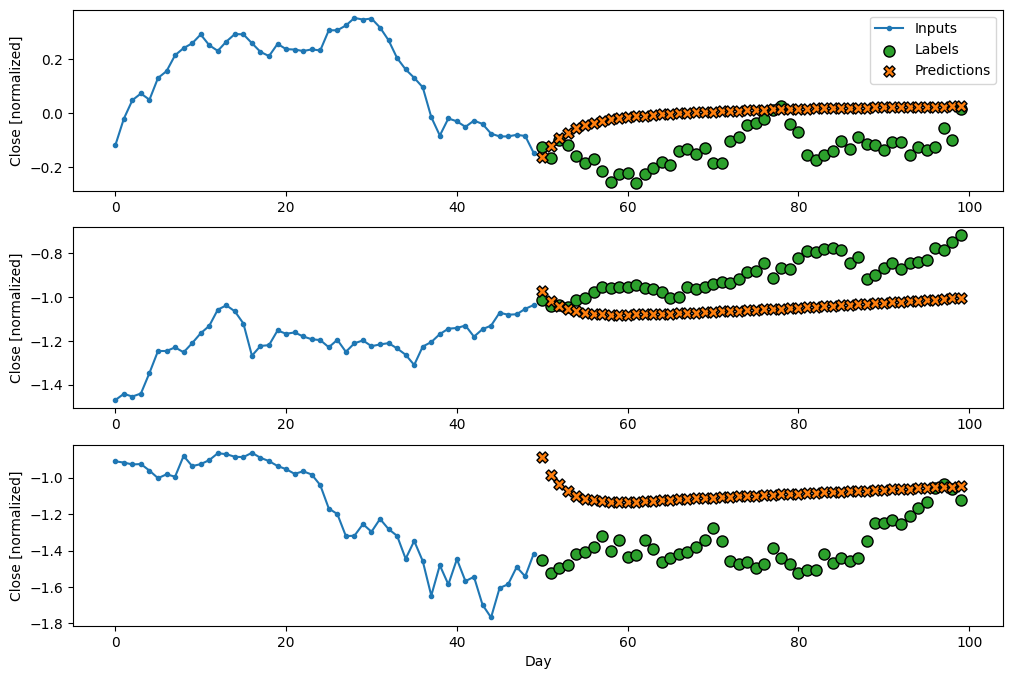

{'Baseline': {'loss': 0.46277499198913574, 'mean_absolute_error': 0.4461108446121216}, 'Repeat': {'loss': 0.48579126596450806, 'mean_absolute_error': 0.531478762626648}, 'Linear': {'loss': 0.175185427069664, 'mean_absolute_error': 0.29054880142211914}, 'Dense': {'loss': 0.21070832014083862, 'mean_absolute_error': 0.33202874660491943}, 'Conv': {'loss': 0.20894239842891693, 'mean_absolute_error': 0.32917848229408264}, 'LSTM': {'loss': 0.5031886696815491, 'mean_absolute_error': 0.5827687978744507}, 'AR LSTM': {'loss': 0.5446034669876099, 'mean_absolute_error': 0.5819046497344971}}
{'Baseline': {'loss': 1.8013306856155396, 'mean_absolute_error': 0.32949164509773254}, 'Repeat': {'loss': 0.48373353481292725, 'mean_absolute_error': 0.25083670020103455}, 'Linear': {'loss': 0.024718668311834335, 'mean_absolute_error': 0.12646523118019104}, 'Dense': {'loss': 0.053757019340991974, 'mean_absolute_error': 0.1885395646095276}, 'Conv': {'loss': 0.04388604685664177, 'mean_absolute_error': 0.1710772365

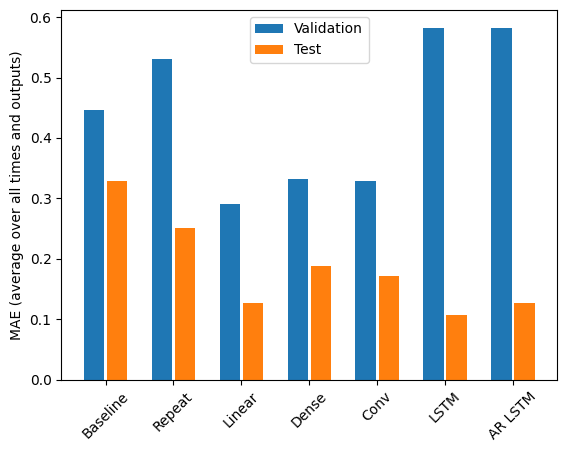

RUNNING EXPERIMENT FOR BG
Baseline 1 (Last Price):
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5608 - mean_absolute_error: 0.5086  


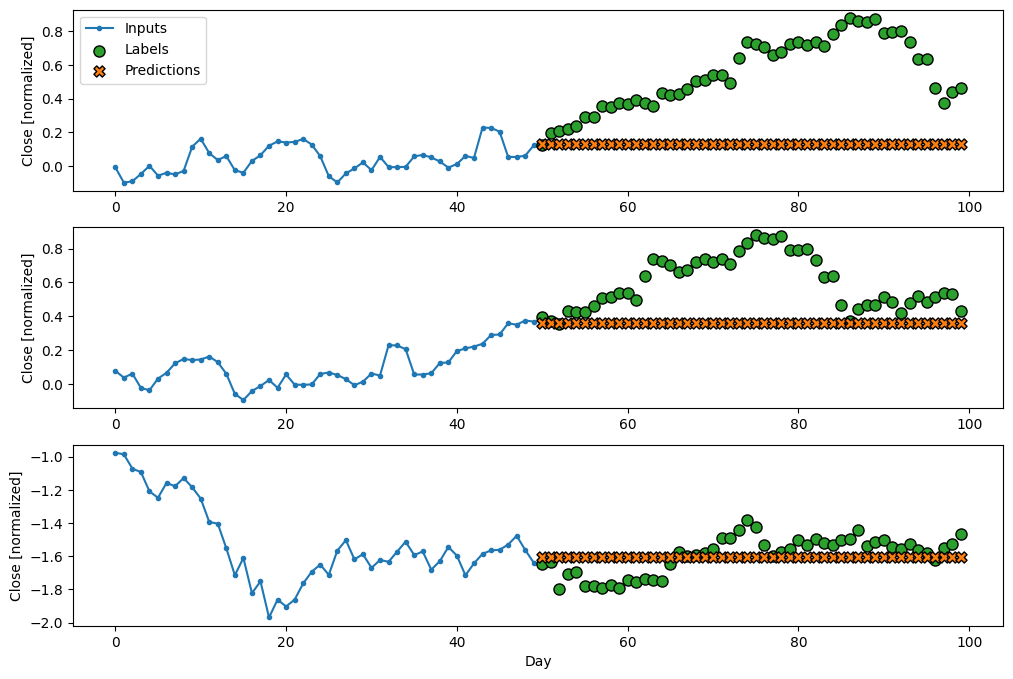

Baseline 2 (Repeat):
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7654 - mean_absolute_error: 0.6265  


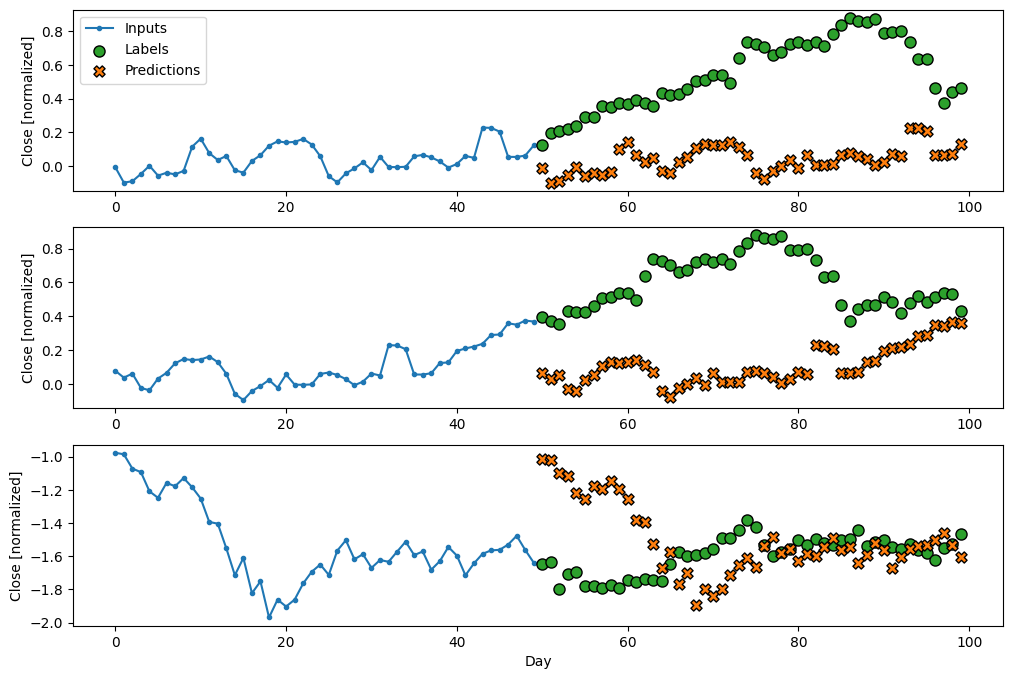

Linear Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9642 - mean_absolute_error: 0.8393 - val_loss: 1.2440 - val_mean_absolute_error: 1.0711
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7415 - mean_absolute_error: 0.7262 - val_loss: 0.9355 - val_mean_absolute_error: 0.9153
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6024 - mean_absolute_error: 0.6488 - val_loss: 0.6949 - val_mean_absolute_error: 0.7713
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4490 - mean_absolute_error: 0.5605 - val_loss: 0.5186 - val_mean_absolute_error: 0.6505
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3453 - mean_absolute_error: 0.4869 - val_loss: 0.3876 - val_mean_absolute_error: 0.5493
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2804 - mean_absolute_error: 0.4358 - val_loss: 0.2957 - val_mean_absolute_error: 0.4670
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2192 - mean_absolute_error: 0.3819 -

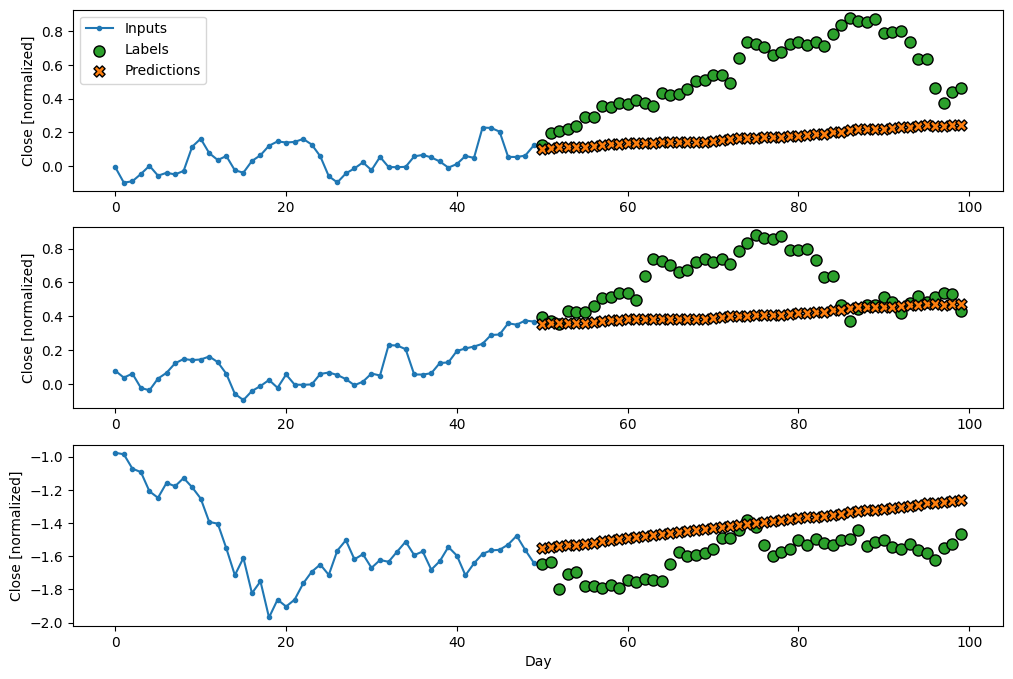

Dense Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.6571 - mean_absolute_error: 0.6648 - val_loss: 0.2413 - val_mean_absolute_error: 0.4167
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1661 - mean_absolute_error: 0.3158 - val_loss: 0.1488 - val_mean_absolute_error: 0.2948
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1172 - mean_absolute_error: 0.2580 - val_loss: 0.1372 - val_mean_absolute_error: 0.2868
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1139 - mean_absolute_error: 0.2525 - val_loss: 0.1346 - val_mean_absolute_error: 0.2846
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1121 - mean_absolute_error: 0.2510 - val_loss: 0.1330 - val_mean_absolute_error: 0.2823
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1117 - mean_absolute_error: 0.2512 - val_loss: 0.1308 - val_mean_absolute_error: 0.2805
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1087 - mean_absolute_error: 0.24

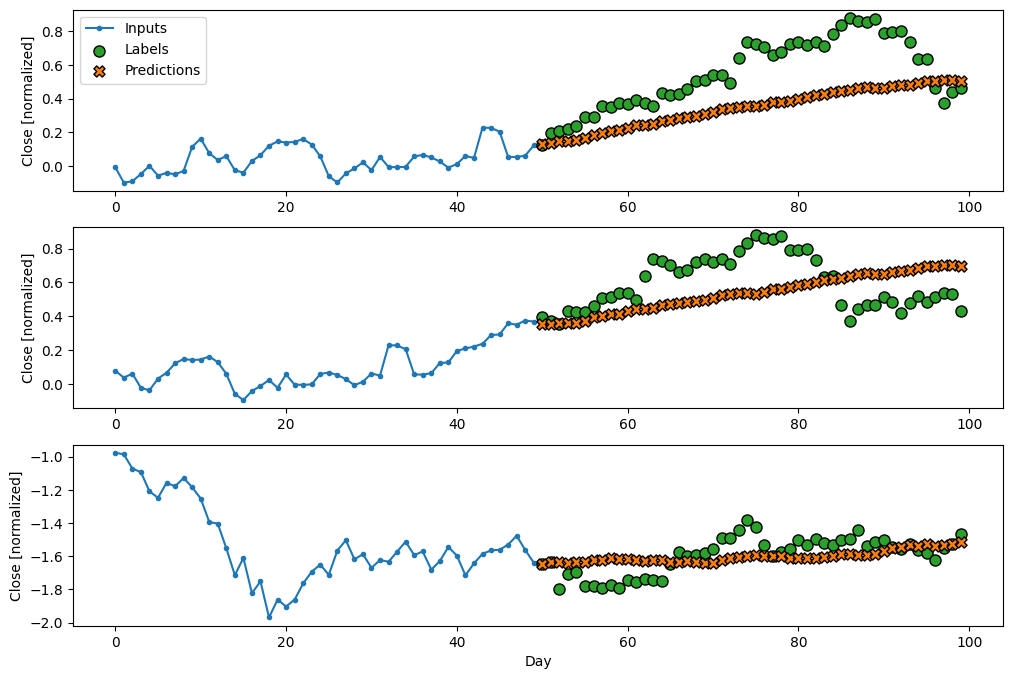

CNN Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.7030 - mean_absolute_error: 0.6950 - val_loss: 0.2184 - val_mean_absolute_error: 0.3964
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1523 - mean_absolute_error: 0.3067 - val_loss: 0.1549 - val_mean_absolute_error: 0.2991
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1275 - mean_absolute_error: 0.2696 - val_loss: 0.1710 - val_mean_absolute_error: 0.3165
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1221 - mean_absolute_error: 0.2617 - val_loss: 0.1610 - val_mean_absolute_error: 0.3099
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1504 - mean_absolute_error: 0.2990 


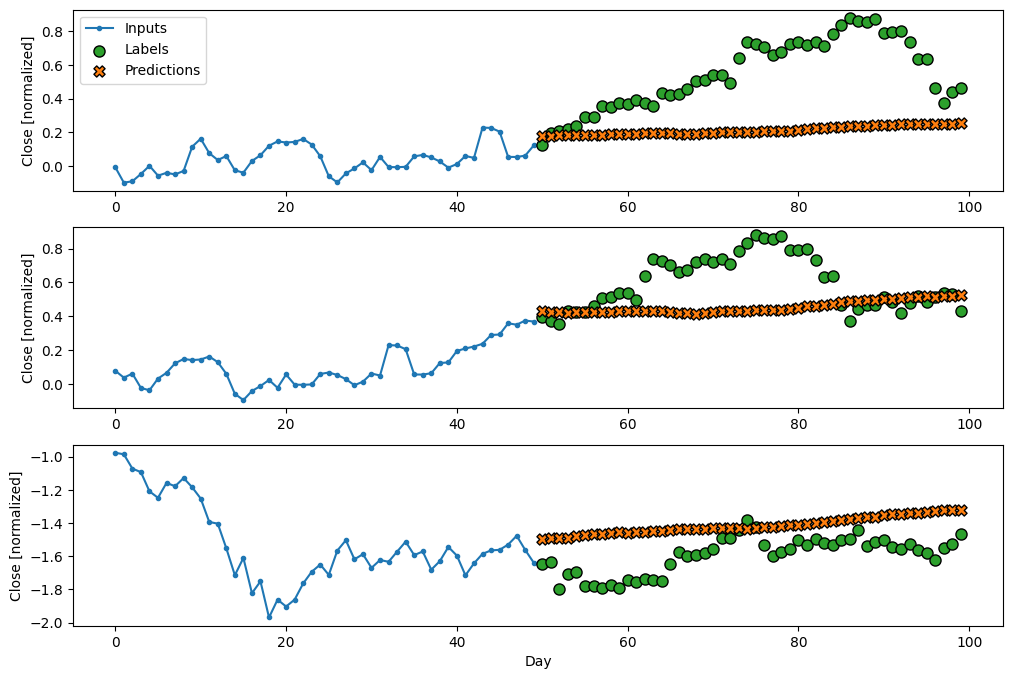

LSTM:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.9620 - mean_absolute_error: 0.8327 - val_loss: 0.9732 - val_mean_absolute_error: 0.9355
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.4634 - mean_absolute_error: 0.5638 - val_loss: 0.3811 - val_mean_absolute_error: 0.5505
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.2094 - mean_absolute_error: 0.3713 - val_loss: 0.2264 - val_mean_absolute_error: 0.4193
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1391 - mean_absolute_error: 0.2960 - val_loss: 0.1529 - val_mean_absolute_error: 0.3336
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1151 - mean_absolute_error: 0.2636 - val_loss: 0.1301 - val_mean_absolute_error: 0.2961
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1095 - mean_absolute_error: 0.2552 - val_loss: 0.1368 - val_mean_absolute_error: 0.2985
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1071 - mean_absolute_error: 0.2519 - va

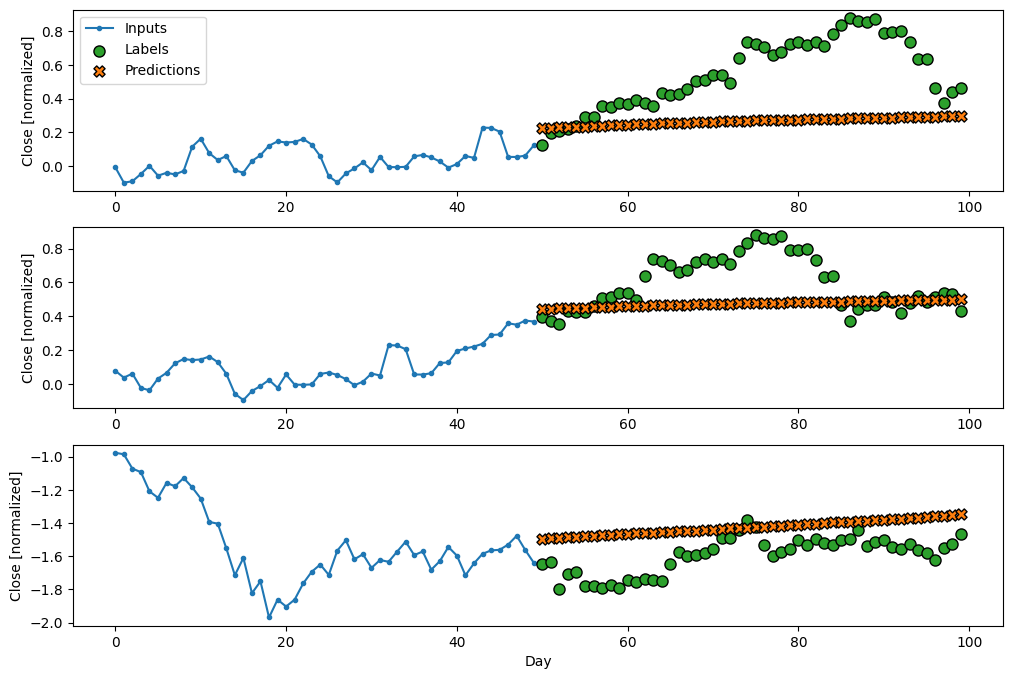

AR LSTM:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - loss: 0.9522 - mean_absolute_error: 0.8234 - val_loss: 0.4355 - val_mean_absolute_error: 0.5509
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.3199 - mean_absolute_error: 0.4540 - val_loss: 0.2448 - val_mean_absolute_error: 0.4333
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.2468 - mean_absolute_error: 0.4052 - val_loss: 0.2348 - val_mean_absolute_error: 0.4250
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.2307 - mean_absolute_error: 0.3888 - val_loss: 0.1781 - val_mean_absolute_error: 0.3669
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1606 - mean_absolute_error: 0.3152 - val_loss: 0.1457 - val_mean_absolute_error: 0.3253
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.1175 - mean_absolute_error: 0.2646 - val_loss: 0.1509 - val_mean_absolute_error: 0.3137
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1177 - mean_absolute_error: 0.2683

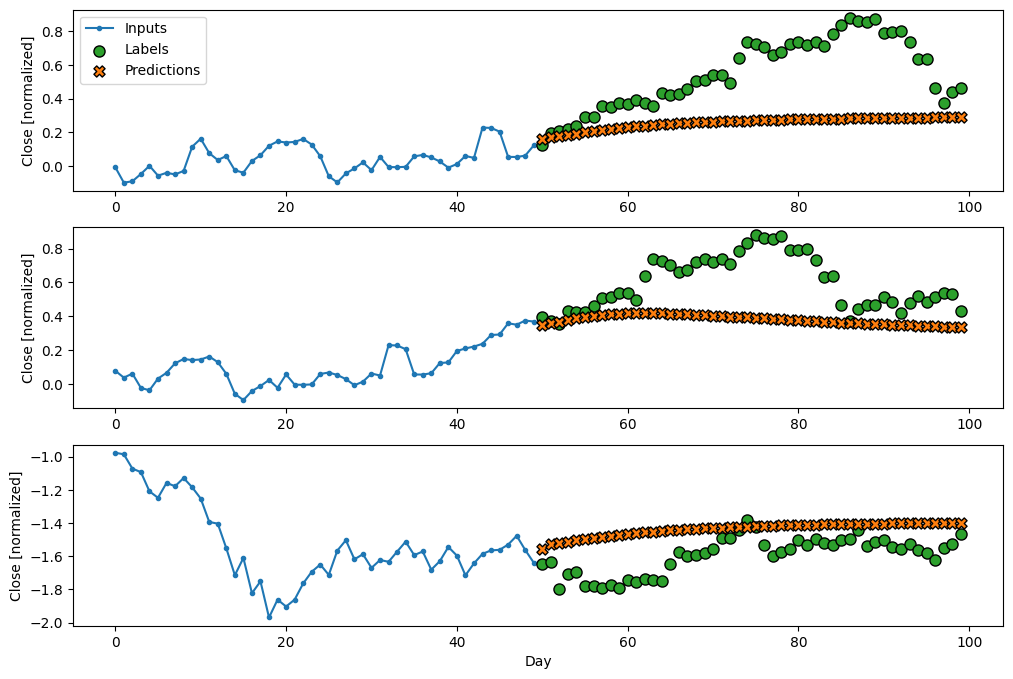

{'Baseline': {'loss': 0.5691574811935425, 'mean_absolute_error': 0.5137554407119751}, 'Repeat': {'loss': 0.7511848211288452, 'mean_absolute_error': 0.6289488077163696}, 'Linear': {'loss': 0.14705264568328857, 'mean_absolute_error': 0.29685527086257935}, 'Dense': {'loss': 0.12857675552368164, 'mean_absolute_error': 0.2785138785839081}, 'Conv': {'loss': 0.1610063910484314, 'mean_absolute_error': 0.3099028468132019}, 'LSTM': {'loss': 0.13954654335975647, 'mean_absolute_error': 0.2996276915073395}, 'AR LSTM': {'loss': 0.18568618595600128, 'mean_absolute_error': 0.3369733691215515}}
{'Baseline': {'loss': 0.47819480299949646, 'mean_absolute_error': 0.4393603801727295}, 'Repeat': {'loss': 0.4268761873245239, 'mean_absolute_error': 0.43278253078460693}, 'Linear': {'loss': 0.0793081596493721, 'mean_absolute_error': 0.24516963958740234}, 'Dense': {'loss': 0.08497786521911621, 'mean_absolute_error': 0.2539607584476471}, 'Conv': {'loss': 0.10669094324111938, 'mean_absolute_error': 0.28236174583435

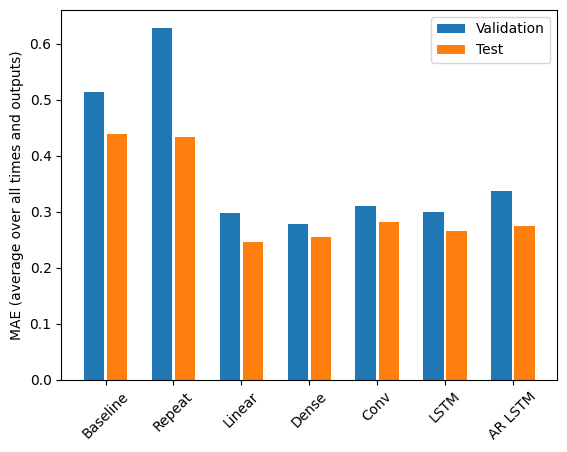

RUNNING EXPERIMENT FOR MOS
Baseline 1 (Last Price):
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1897 - mean_absolute_error: 0.2945  


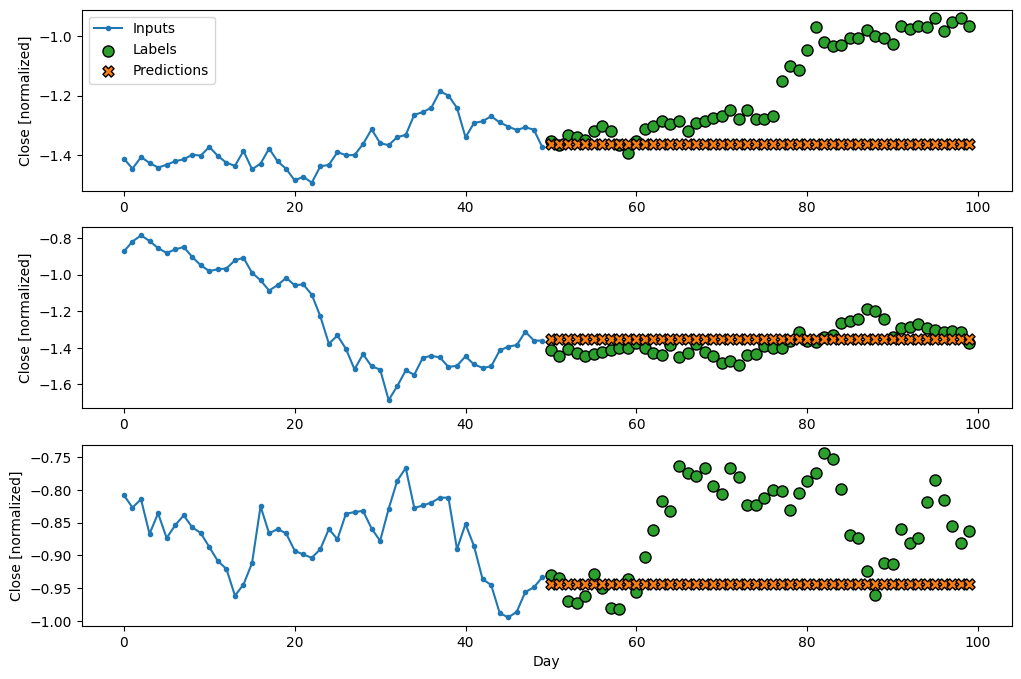

Baseline 2 (Repeat):
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2056 - mean_absolute_error: 0.3382  


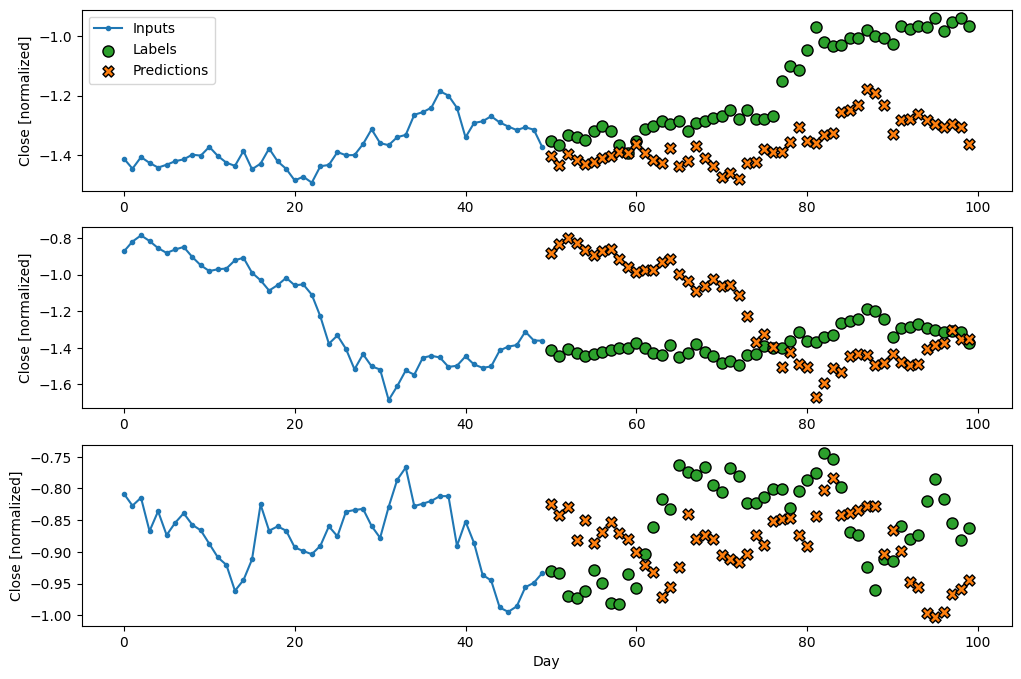

Linear Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9943 - mean_absolute_error: 0.8338 - val_loss: 0.0442 - val_mean_absolute_error: 0.1748
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7450 - mean_absolute_error: 0.7152 - val_loss: 0.0412 - val_mean_absolute_error: 0.1684
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6137 - mean_absolute_error: 0.6421 - val_loss: 0.0392 - val_mean_absolute_error: 0.1638
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4642 - mean_absolute_error: 0.5479 - val_loss: 0.0383 - val_mean_absolute_error: 0.1614
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3869 - mean_absolute_error: 0.4870 - val_loss: 0.0381 - val_mean_absolute_error: 0.1603
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2930 - mean_absolute_error: 0.4181 - val_loss: 0.0383 - val_mean_absolute_error: 0.1602
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2448 - mean_absolute_error: 0.3763 

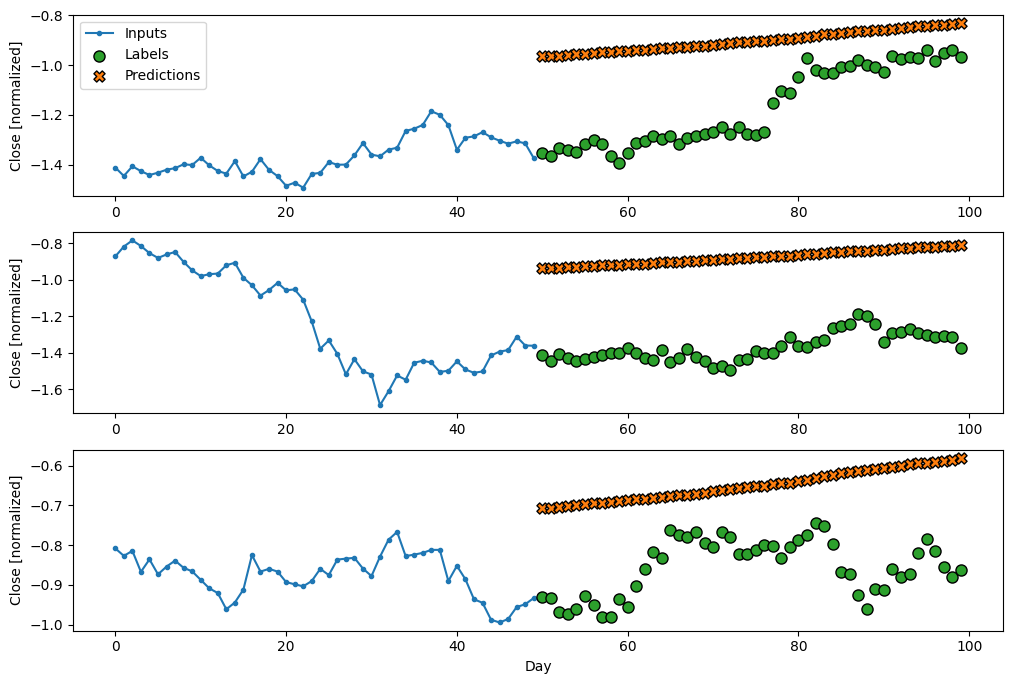

Dense Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.7058 - mean_absolute_error: 0.6727 - val_loss: 0.0597 - val_mean_absolute_error: 0.1989
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1726 - mean_absolute_error: 0.2991 - val_loss: 0.0493 - val_mean_absolute_error: 0.1794
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1300 - mean_absolute_error: 0.2425 - val_loss: 0.0648 - val_mean_absolute_error: 0.2058
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1403 - mean_absolute_error: 0.2500 - val_loss: 0.0691 - val_mean_absolute_error: 0.2100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0706 - mean_absolute_error: 0.2126 


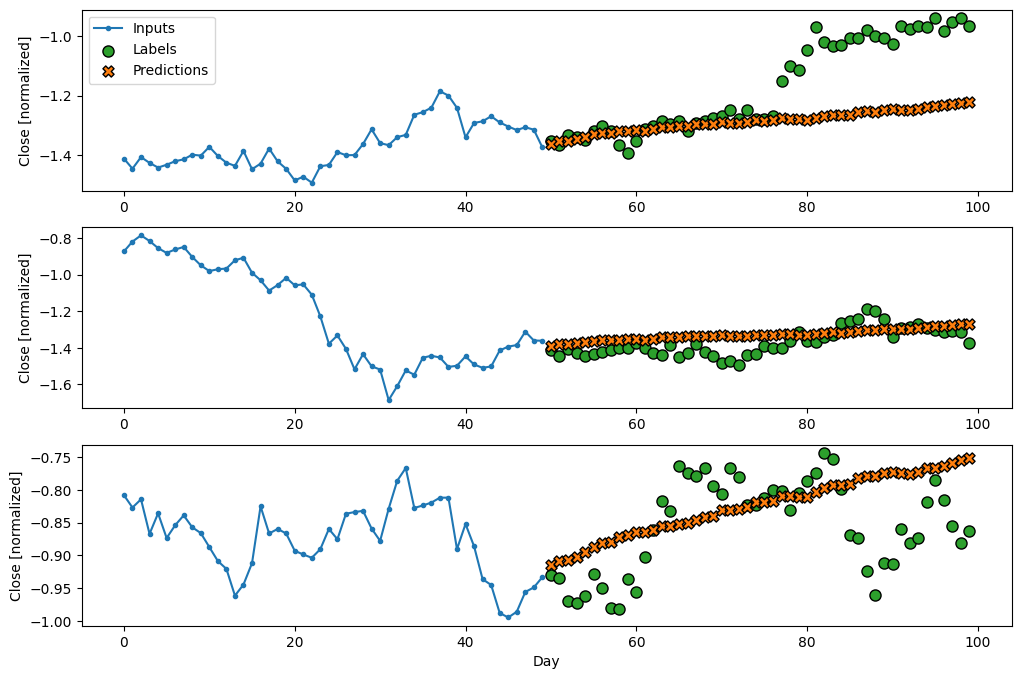

CNN Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6890 - mean_absolute_error: 0.6592 - val_loss: 0.0574 - val_mean_absolute_error: 0.1969
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1927 - mean_absolute_error: 0.3148 - val_loss: 0.0431 - val_mean_absolute_error: 0.1664
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1368 - mean_absolute_error: 0.2449 - val_loss: 0.0473 - val_mean_absolute_error: 0.1731
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1281 - mean_absolute_error: 0.2385 - val_loss: 0.0546 - val_mean_absolute_error: 0.1868
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0528 - mean_absolute_error: 0.1823 


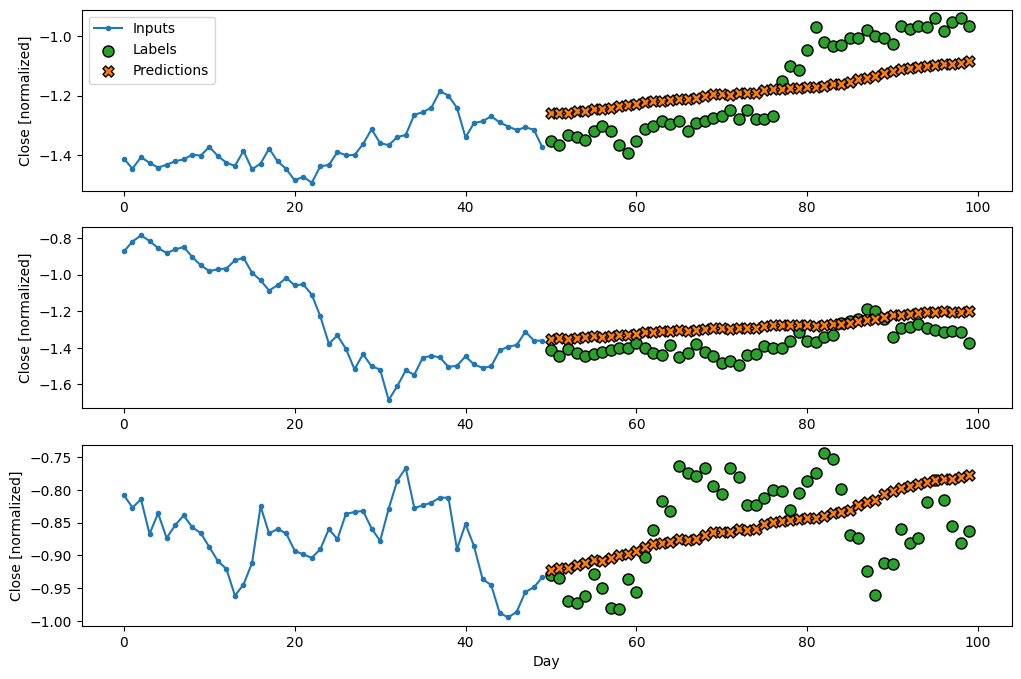

LSTM:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.9190 - mean_absolute_error: 0.7818 - val_loss: 0.0318 - val_mean_absolute_error: 0.1432
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.4474 - mean_absolute_error: 0.5342 - val_loss: 0.2044 - val_mean_absolute_error: 0.4046
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.2060 - mean_absolute_error: 0.3355 - val_loss: 0.1429 - val_mean_absolute_error: 0.3127
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1433 - mean_absolute_error: 0.3105 


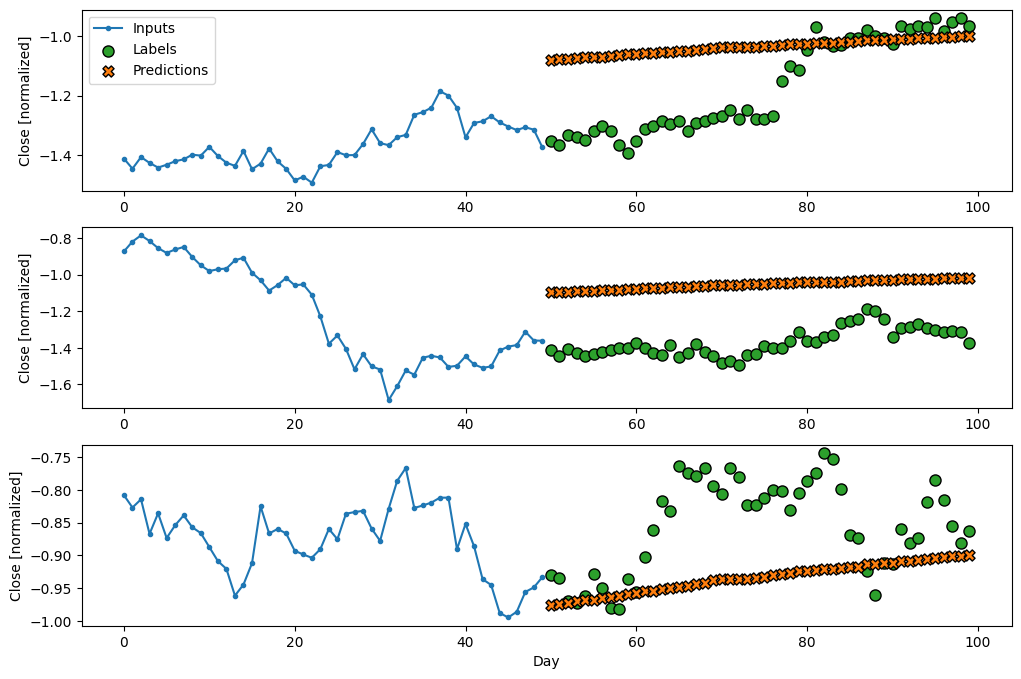

AR LSTM:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - loss: 1.0195 - mean_absolute_error: 0.8325 - val_loss: 0.5910 - val_mean_absolute_error: 0.6231
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.4410 - mean_absolute_error: 0.5335 - val_loss: 0.3910 - val_mean_absolute_error: 0.5223
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.2685 - mean_absolute_error: 0.4161 - val_loss: 0.4205 - val_mean_absolute_error: 0.5370
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1640 - mean_absolute_error: 0.3007 - val_loss: 0.2434 - val_mean_absolute_error: 0.3763
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.1468 - mean_absolute_error: 0.2821 - val_loss: 0.2097 - val_mean_absolute_error: 0.3477
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.1360 - mean_absolute_error: 0.2724 - val_loss: 0.2759 - val_mean_absolute_error: 0.3898
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1316 - mean_absolute_error: 0.2689

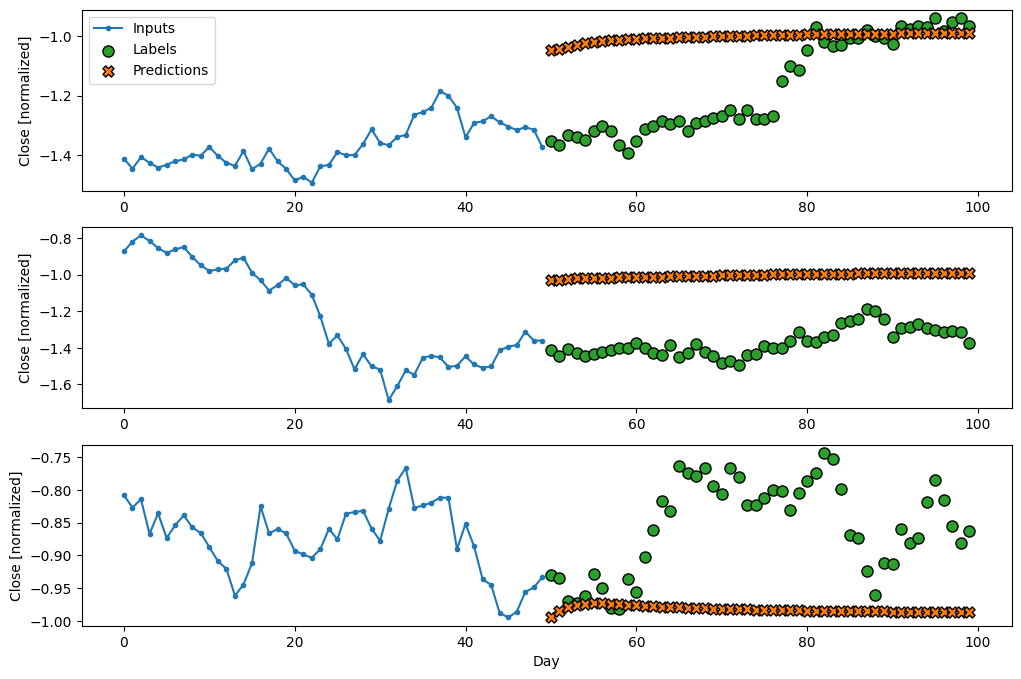

{'Baseline': {'loss': 0.1844036877155304, 'mean_absolute_error': 0.2908875346183777}, 'Repeat': {'loss': 0.20869293808937073, 'mean_absolute_error': 0.3434632122516632}, 'Linear': {'loss': 0.03887359797954559, 'mean_absolute_error': 0.16079646348953247}, 'Dense': {'loss': 0.06905890256166458, 'mean_absolute_error': 0.20999813079833984}, 'Conv': {'loss': 0.05456949397921562, 'mean_absolute_error': 0.18678708374500275}, 'LSTM': {'loss': 0.14286021888256073, 'mean_absolute_error': 0.3126528263092041}, 'AR LSTM': {'loss': 0.12603974342346191, 'mean_absolute_error': 0.26435577869415283}}
{'Baseline': {'loss': 0.12519310414791107, 'mean_absolute_error': 0.16671441495418549}, 'Repeat': {'loss': 0.1143903136253357, 'mean_absolute_error': 0.21482573449611664}, 'Linear': {'loss': 0.04268169030547142, 'mean_absolute_error': 0.17849470674991608}, 'Dense': {'loss': 0.05303950607776642, 'mean_absolute_error': 0.1951567679643631}, 'Conv': {'loss': 0.04852117598056793, 'mean_absolute_error': 0.1907502

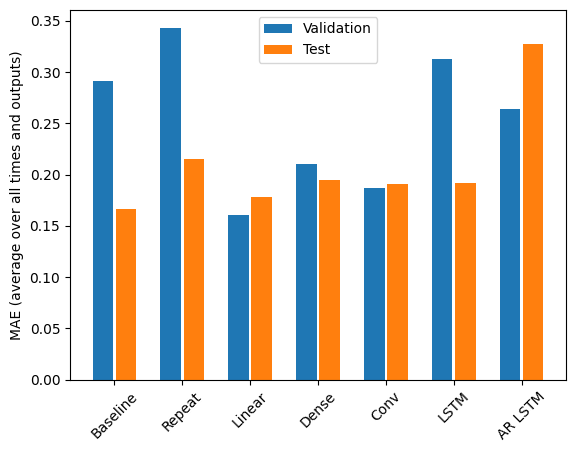

RUNNING EXPERIMENT FOR CTVA
Baseline 1 (Last Price):
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2556 - mean_absolute_error: 0.3244  


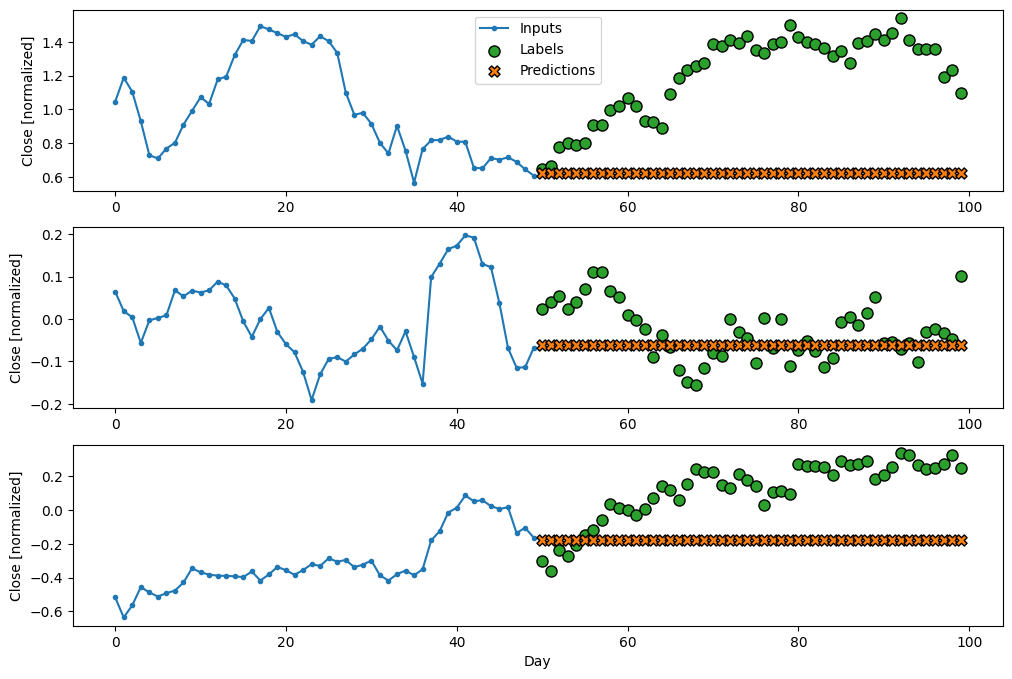

Baseline 2 (Repeat):
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3365 - mean_absolute_error: 0.4326  


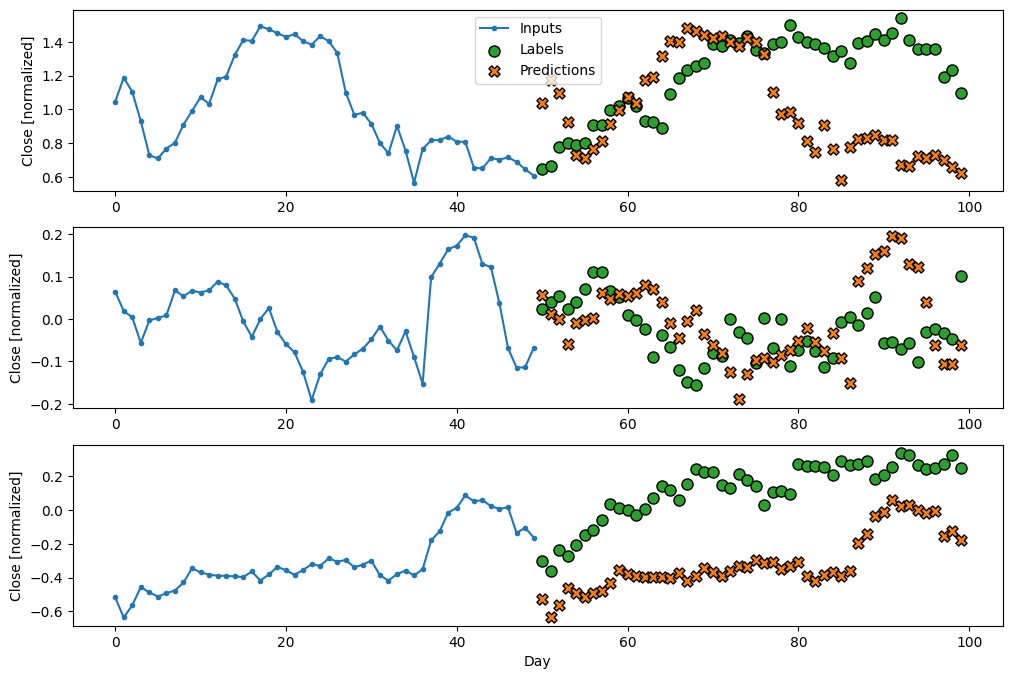

Linear Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8800 - mean_absolute_error: 0.7824 - val_loss: 0.2506 - val_mean_absolute_error: 0.4282
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6707 - mean_absolute_error: 0.6807 - val_loss: 0.1828 - val_mean_absolute_error: 0.3552
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4869 - mean_absolute_error: 0.5725 - val_loss: 0.1335 - val_mean_absolute_error: 0.2936
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3706 - mean_absolute_error: 0.4975 - val_loss: 0.0996 - val_mean_absolute_error: 0.2462
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2813 - mean_absolute_error: 0.4301 - val_loss: 0.0798 - val_mean_absolute_error: 0.2195
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2102 - mean_absolute_error: 0.3658 - val_loss: 0.0695 - val_mean_absolute_error: 0.2070
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1699 - mean_absolute_error: 0.3261 -

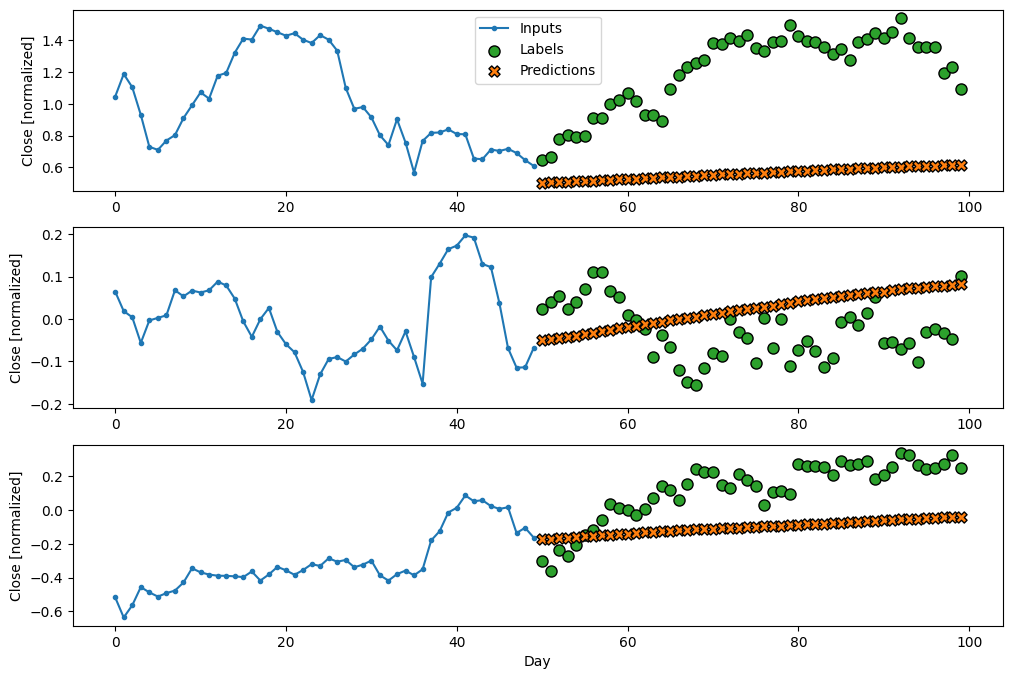

Dense Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.5913 - mean_absolute_error: 0.6103 - val_loss: 0.1894 - val_mean_absolute_error: 0.3718
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1089 - mean_absolute_error: 0.2609 - val_loss: 0.0690 - val_mean_absolute_error: 0.2063
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0777 - mean_absolute_error: 0.2151 - val_loss: 0.0904 - val_mean_absolute_error: 0.2426
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0720 - mean_absolute_error: 0.2079 - val_loss: 0.0951 - val_mean_absolute_error: 0.2505
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0936 - mean_absolute_error: 0.2487 


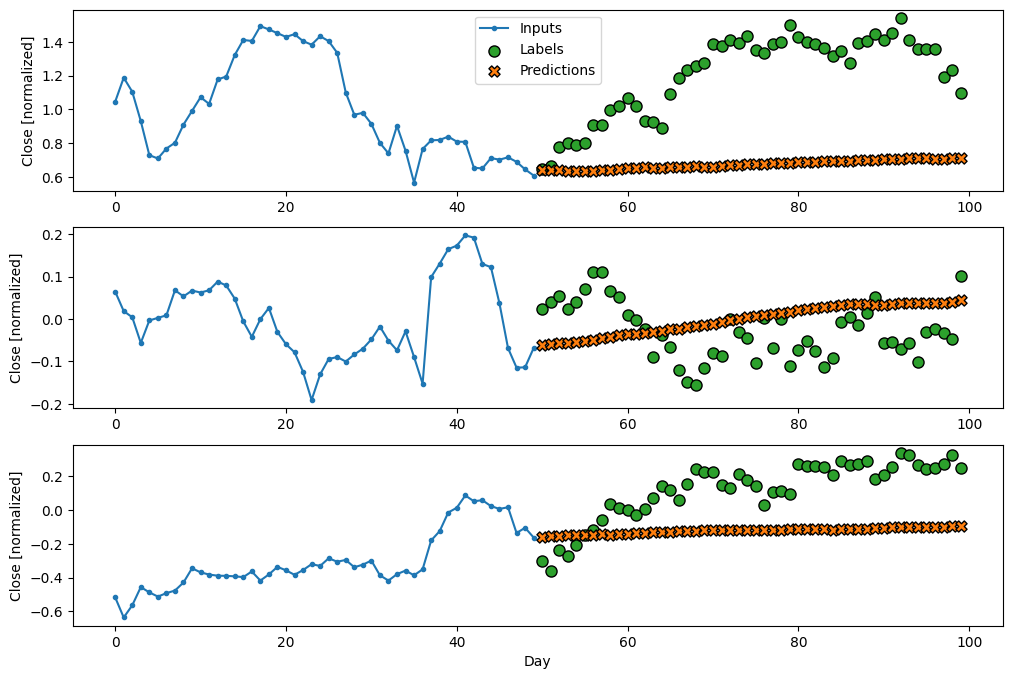

CNN Model:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.6414 - mean_absolute_error: 0.6435 - val_loss: 0.1774 - val_mean_absolute_error: 0.3559
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1156 - mean_absolute_error: 0.2684 - val_loss: 0.0738 - val_mean_absolute_error: 0.2130
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0793 - mean_absolute_error: 0.2216 - val_loss: 0.0843 - val_mean_absolute_error: 0.2305
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0760 - mean_absolute_error: 0.2152 - val_loss: 0.0852 - val_mean_absolute_error: 0.2324
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0835 - mean_absolute_error: 0.2283 


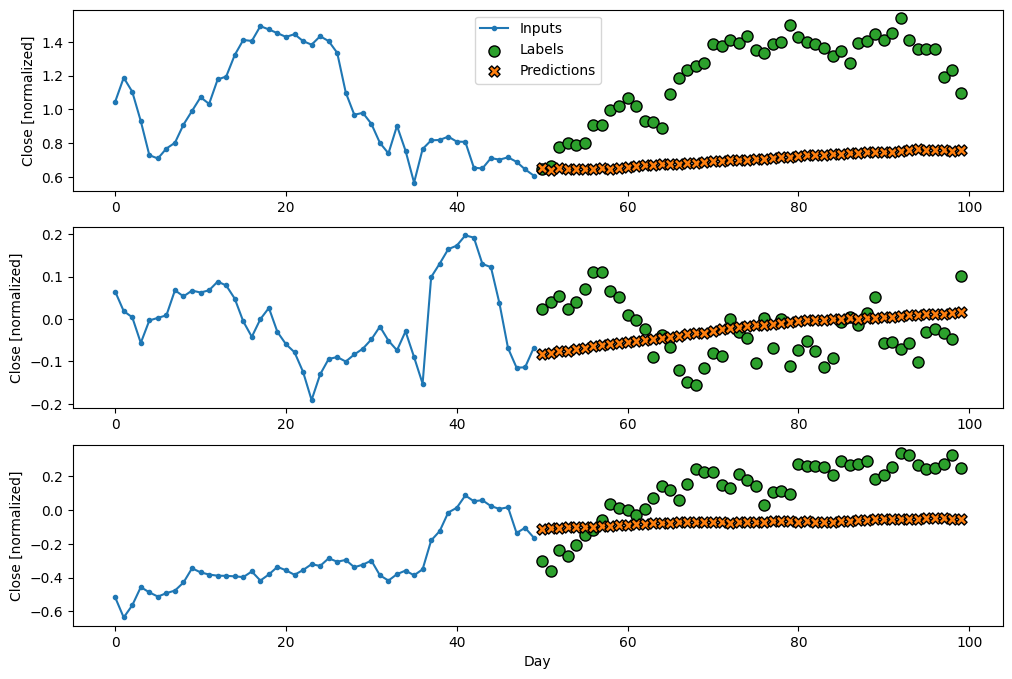

LSTM:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.8590 - mean_absolute_error: 0.7688 - val_loss: 0.1255 - val_mean_absolute_error: 0.2764
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.3965 - mean_absolute_error: 0.5219 - val_loss: 0.0922 - val_mean_absolute_error: 0.2702
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1428 - mean_absolute_error: 0.3131 - val_loss: 0.2086 - val_mean_absolute_error: 0.4048
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0697 - mean_absolute_error: 0.2115 - val_loss: 0.2659 - val_mean_absolute_error: 0.4570
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2745 - mean_absolute_error: 0.4650


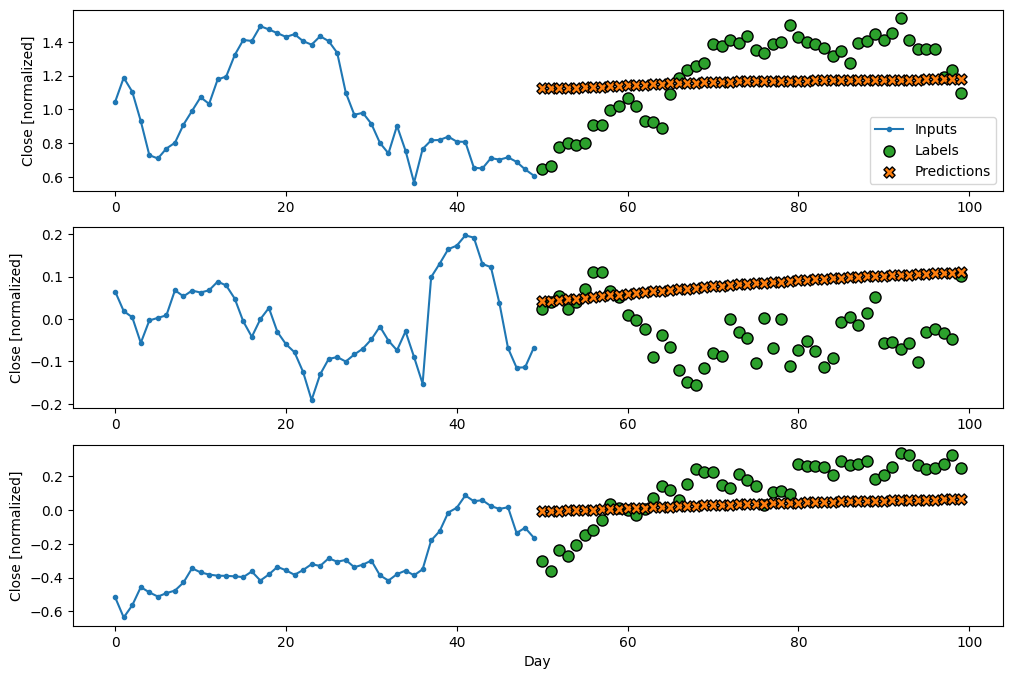

AR LSTM:
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - loss: 0.9146 - mean_absolute_error: 0.7935 - val_loss: 0.1287 - val_mean_absolute_error: 0.2852
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.4188 - mean_absolute_error: 0.5367 - val_loss: 0.0752 - val_mean_absolute_error: 0.2304
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.2079 - mean_absolute_error: 0.3800 - val_loss: 0.1827 - val_mean_absolute_error: 0.3598
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0913 - mean_absolute_error: 0.2333 - val_loss: 0.2677 - val_mean_absolute_error: 0.4373
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2693 - mean_absolute_error: 0.4381


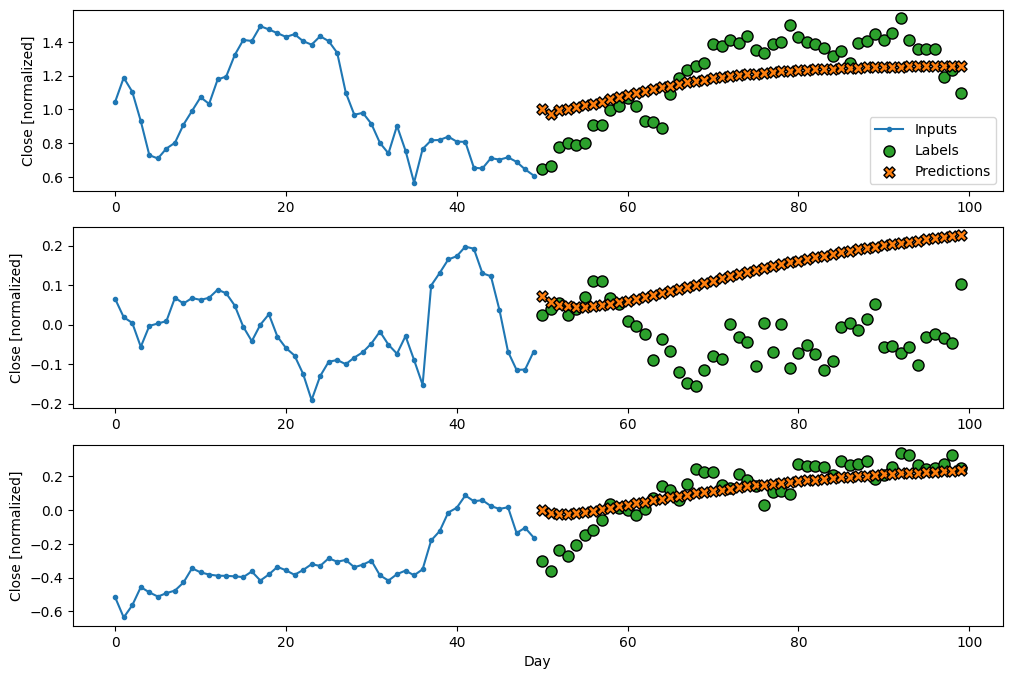

{'Baseline': {'loss': 0.25614112615585327, 'mean_absolute_error': 0.3257163166999817}, 'Repeat': {'loss': 0.3302745223045349, 'mean_absolute_error': 0.4294748306274414}, 'Linear': {'loss': 0.07020768523216248, 'mean_absolute_error': 0.2098507136106491}, 'Dense': {'loss': 0.09514474868774414, 'mean_absolute_error': 0.25049465894699097}, 'Conv': {'loss': 0.08519899100065231, 'mean_absolute_error': 0.23240172863006592}, 'LSTM': {'loss': 0.2658972442150116, 'mean_absolute_error': 0.45697805285453796}, 'AR LSTM': {'loss': 0.2676745057106018, 'mean_absolute_error': 0.43733733892440796}}
{'Baseline': {'loss': 0.2821477949619293, 'mean_absolute_error': 0.31393522024154663}, 'Repeat': {'loss': 0.30147165060043335, 'mean_absolute_error': 0.3783149719238281}, 'Linear': {'loss': 0.03174670785665512, 'mean_absolute_error': 0.14701202511787415}, 'Dense': {'loss': 0.03527418524026871, 'mean_absolute_error': 0.15175046026706696}, 'Conv': {'loss': 0.03310375288128853, 'mean_absolute_error': 0.148650631

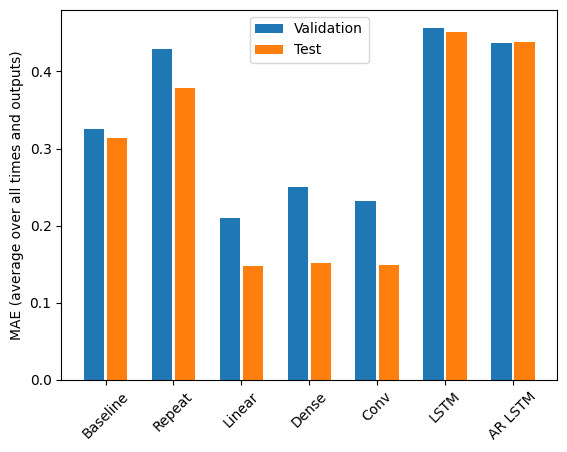

In [26]:
run_group_experiment()